In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 1
2023-07-28 23:06:32.117419


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-4.7190)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-5.4964)
penalty_target_min tensor(-11.3380) penalty_target_max tensor(7.8557)
train_loss:  -8.237324515533448
valid_loss:  -7.70716544342041
h_min_tilde -11.33799 ell_tilde -8.13129270111084 kappa_tilde 0.0005584329428254637


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 5.44878888130188

 2 7.023881435394287

 3 7.022611856460571

 4 6.990633010864258

 5 6.833496570587158

 6 6.843663215637207

 7 6.885793924331665

 8 4.76895546913147

 9 3.250236749649048

 10 3.512383222579956

 11 3.5549895763397217

 12 3.548881769180298

 13 3.4157462120056152

 14 3.6150355339050293

 15 4.813000440597534

 16 7.034868240356445

 17 5.008947134017944

 18 3.4566872119903564

 19 3.4239606857299805

 20 3.575624465942383

 21 3.422030210494995

 22 3.8267157077789307

 23 3.725236415863037

 24 3.4521825313568115

 25 3.4950754642486572

 26 3.478950023651123

 27 3.5121421813964844

 28 3.662400484085083

 29 3.795424222946167

 30 3.635690212249756

 31 3.783635139465332

 32 3.454275131225586

 33 3.489297389984131

 34 3.621126651763916

 35 3.5109474658966064

 36 3.5547451972961426

 37 3.7708194255828857

 38 3.410304546356201

 39 4.696404218673706

 40 7.144154071807861

 41 4.732796907424927

 42 3.589341640472412

 43 3.923097848892212

 44 3.381

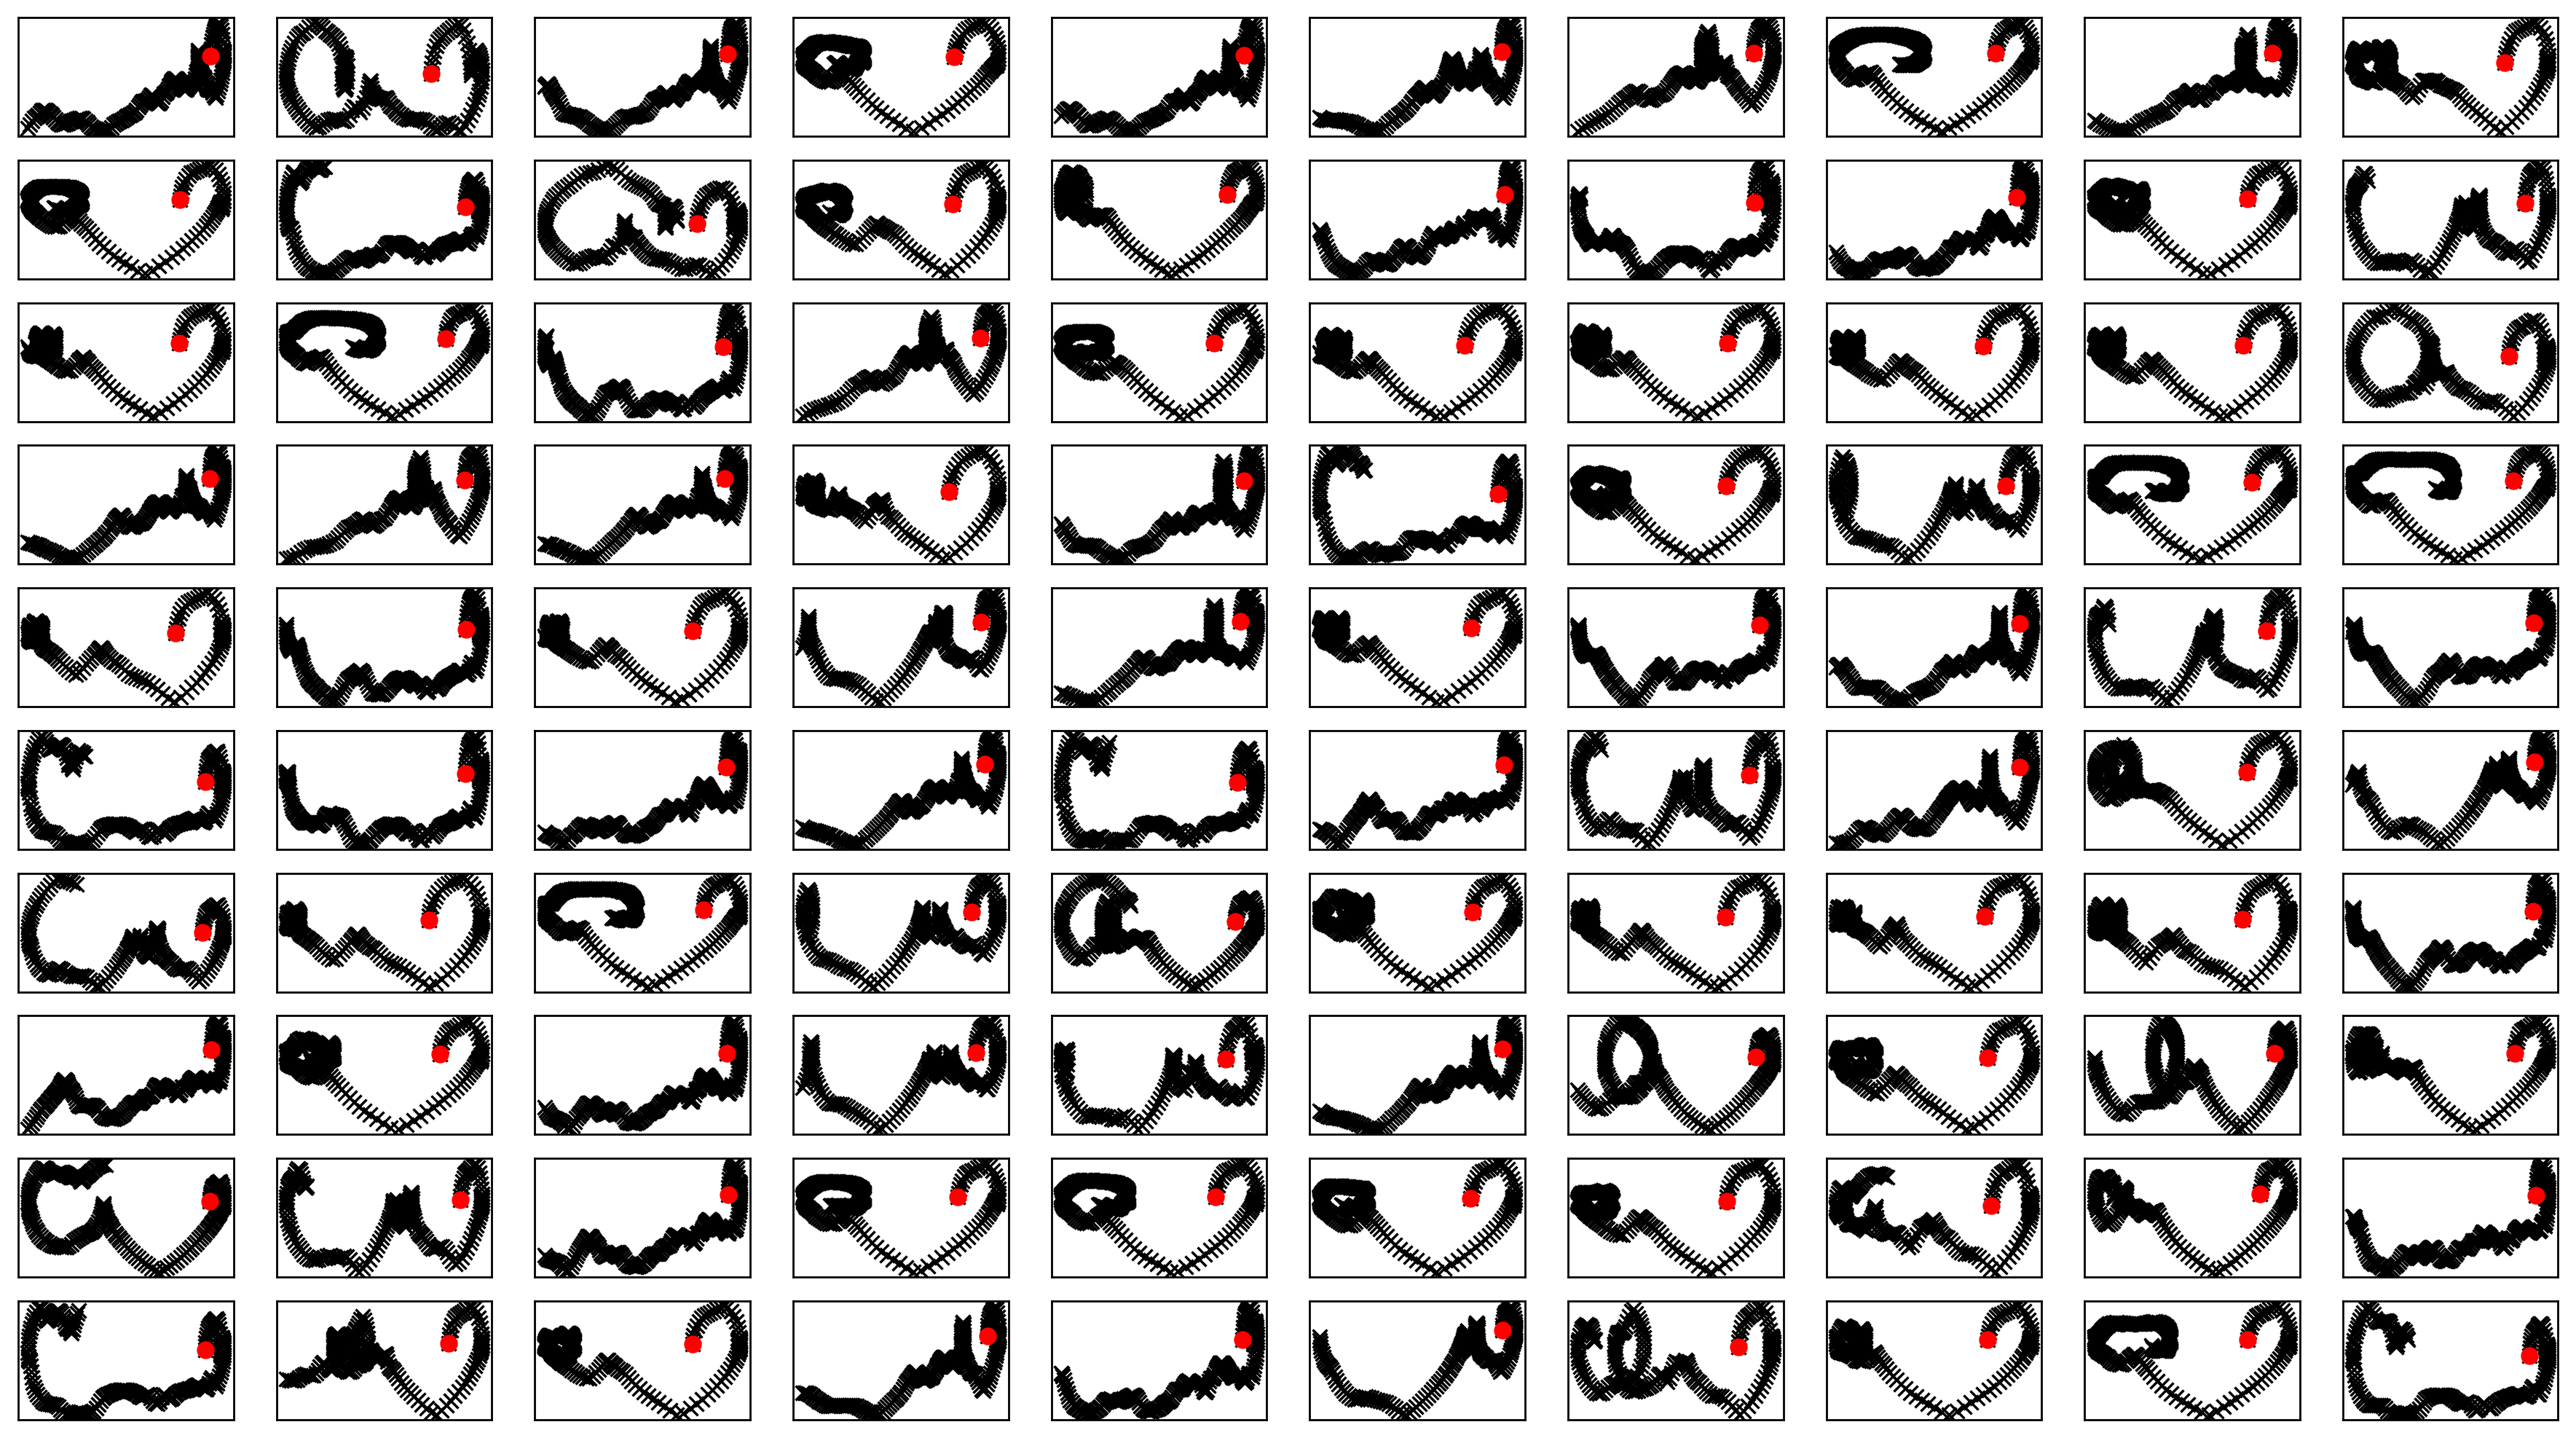

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

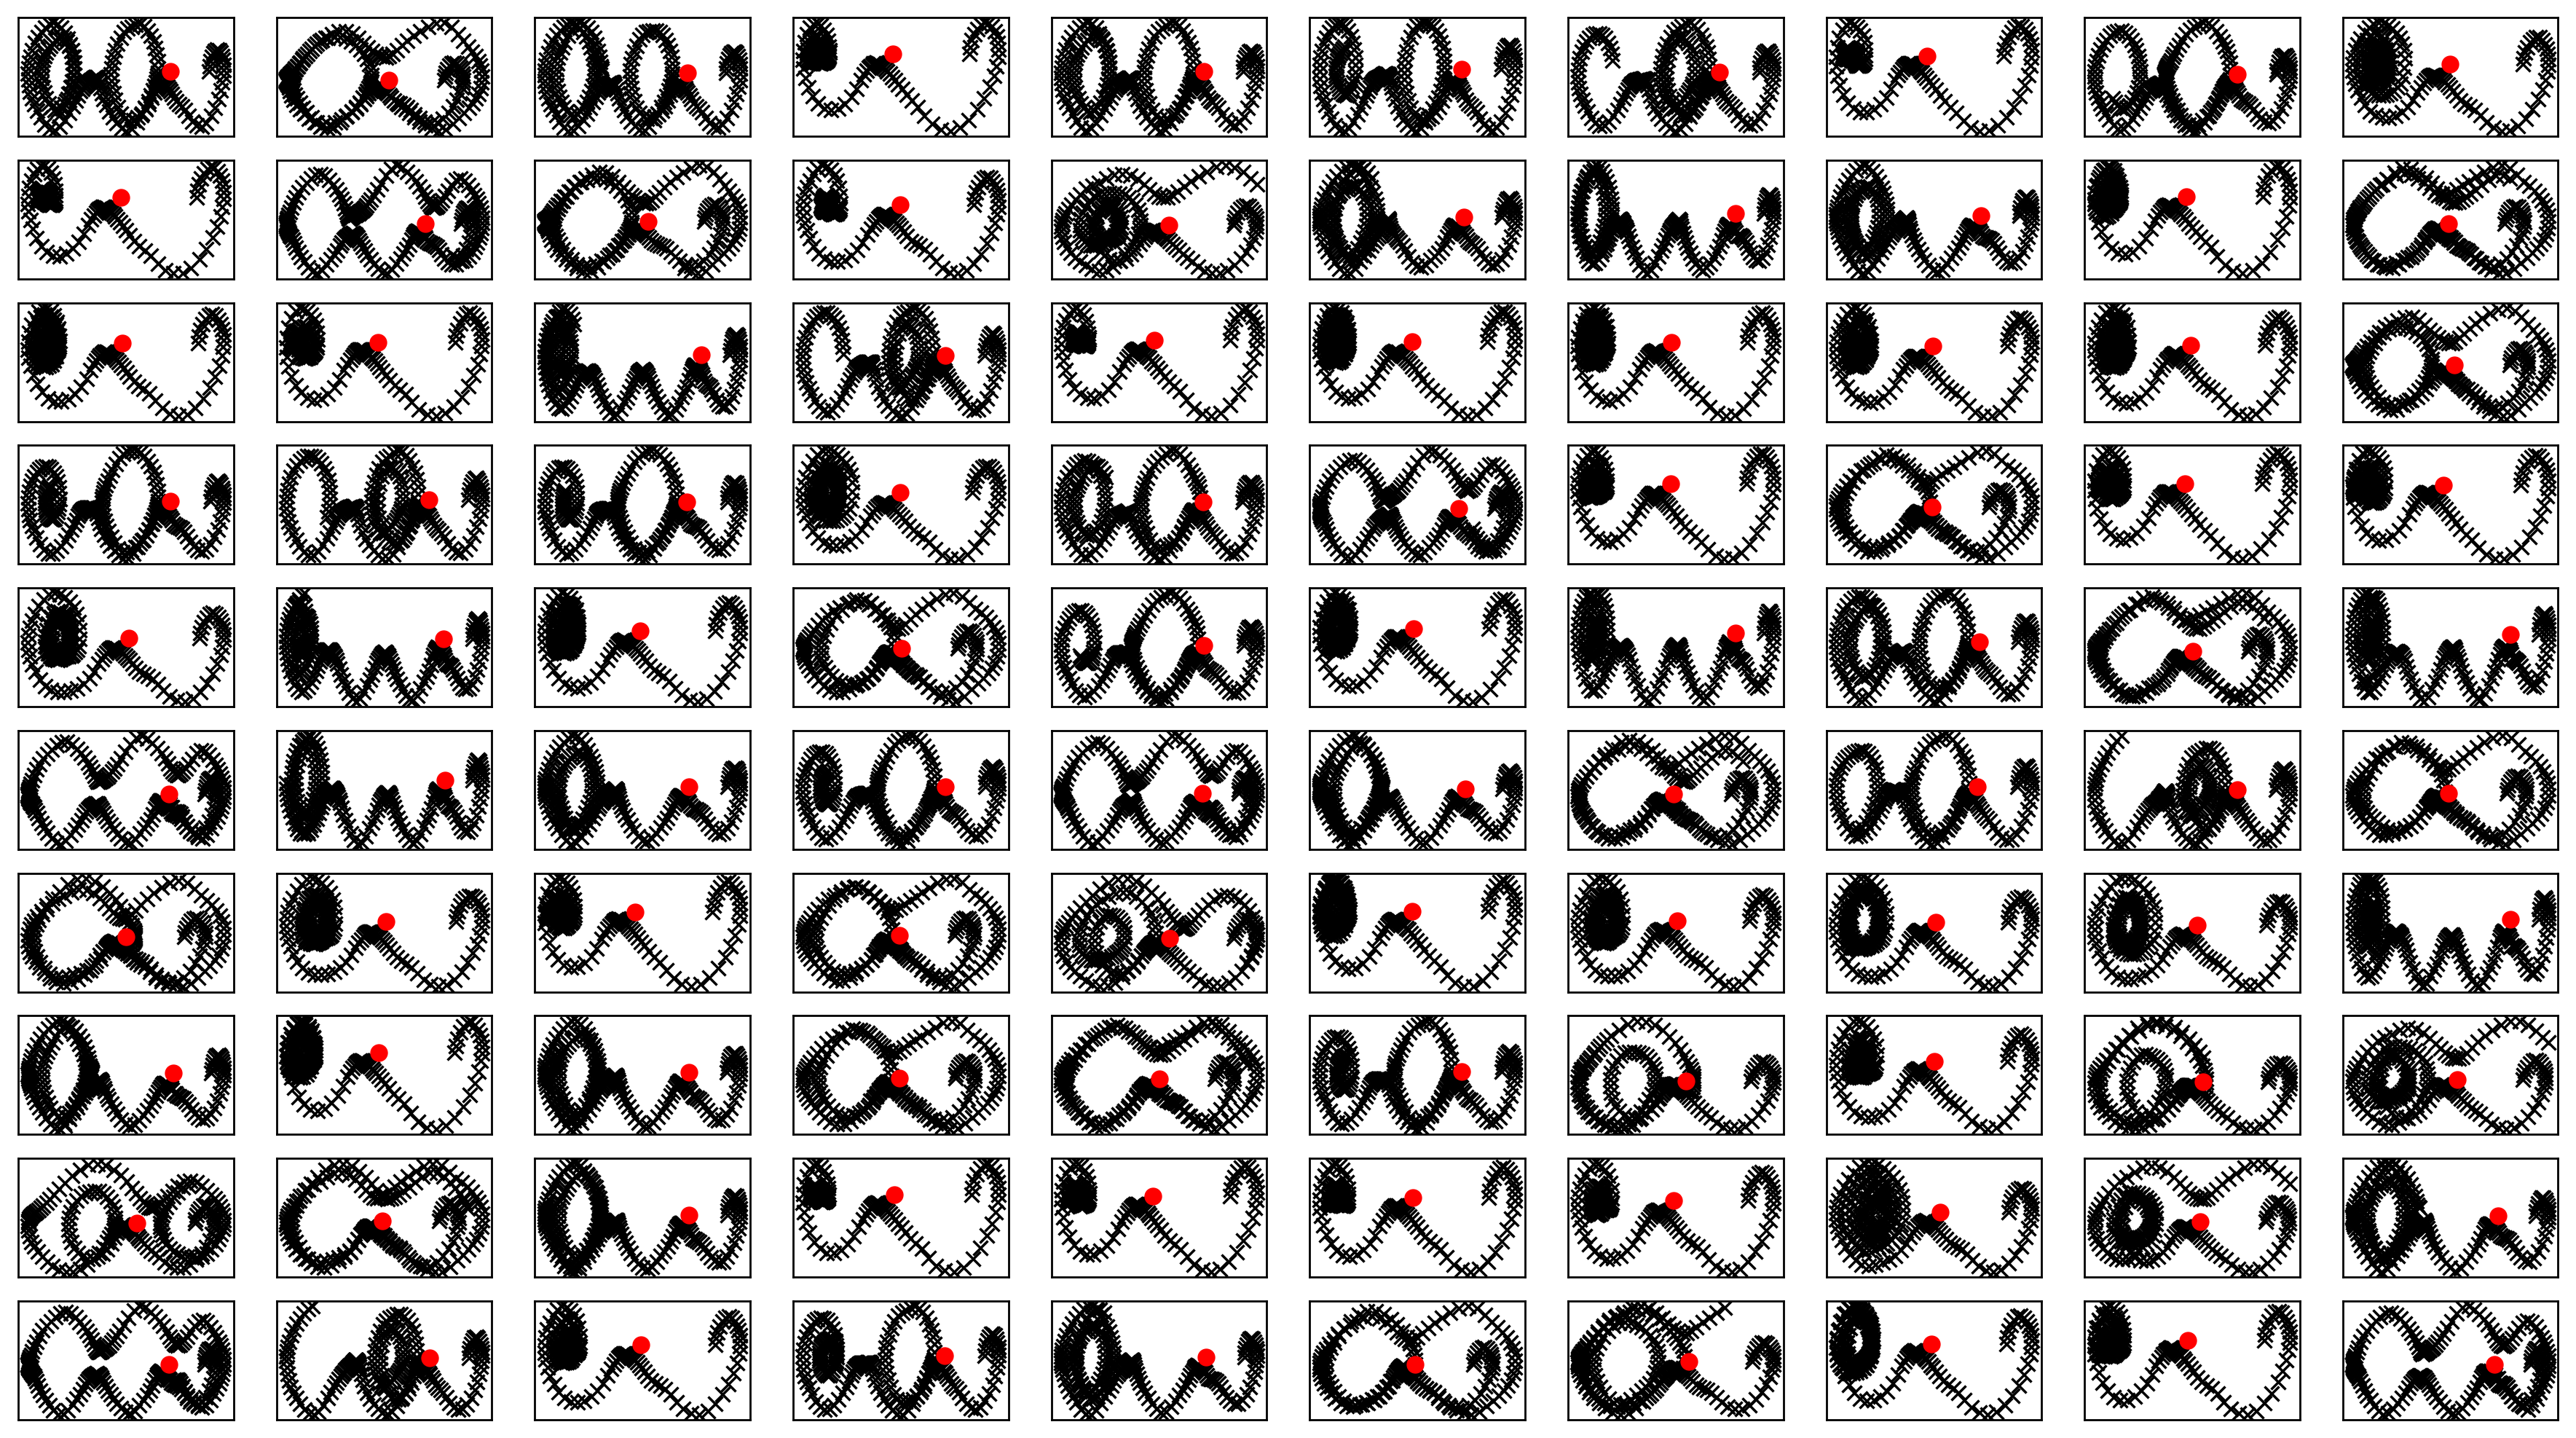

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-28 23:13:37.401926


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-53.57768965  39.85544461 -12.92227196 -24.12351064] [ 0.2476284  34.16615738 -1.01181872 -2.91134276] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 160

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.32656  validloss 1.41093±0.00000  bestvalidloss 1.41093  last_update 0
train: iter 1  trainloss 1.18989  validloss 1.31330±0.00000  bestvalidloss 1.31330  last_update 0
train: iter 2  trainloss 1.09138  validloss 1.25442±0.00000  bestvalidloss 1.25442  last_update 0
train: iter 3  trainloss 1.01321  validloss 1.16780±0.00000  bestvalidloss 1.16780  last_update 0
train: iter 4  trainloss 0.95949  validloss 1.11392±0.00000  bestvalidloss 1.11392  last_update 0
train: iter 5  trainloss 0.92227  validloss 1.08328±0.00000  bestvalidloss 1.08328  last_update 0
train: iter 6  trainloss 0.89867  validloss 1.06368±0.00000  bestvalidloss 1.06368  last_update 0
train: iter 7  trainloss 0.87364  validloss 1.05114±0.00000  bestvalidloss 1.05114  last_update 0
train: iter 8  trainloss 0.85215  validloss 1.02238±0.00000  bestvalidloss 1.02238  last_update 0
train: iter 9  trainloss 0.83160  validloss 0.99260±0.00000  bestvalidloss 0.99260  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.52770  validloss 0.56217±0.00000  bestvalidloss 0.54169  last_update 1
train: iter 84  trainloss 0.52064  validloss 0.54618±0.00000  bestvalidloss 0.54169  last_update 2
train: iter 85  trainloss 0.51829  validloss 0.54388±0.00000  bestvalidloss 0.54169  last_update 3
train: iter 86  trainloss 0.51708  validloss 0.54634±0.00000  bestvalidloss 0.54169  last_update 4
train: iter 87  trainloss 0.51726  validloss 0.54772±0.00000  bestvalidloss 0.54169  last_update 5
train: iter 88  trainloss 0.51100  validloss 0.53292±0.00000  bestvalidloss 0.53292  last_update 0
train: iter 89  trainloss 0.51922  validloss 0.55008±0.00000  bestvalidloss 0.53292  last_update 1
train: iter 90  trainloss 0.51615  validloss 0.54901±0.00000  bestvalidloss 0.53292  last_update 2
train: iter 91  trainloss 0.51940  validloss 0.56502±0.00000  bestvalidloss 0.53292  last_update 3
train: iter 92  trainloss 0.51401  validloss 0.54430±0.00000  bestvalidloss 0.53292  last_update 4
train: ite

train: iter 165  trainloss 0.47656  validloss 0.50514±0.00000  bestvalidloss 0.49886  last_update 6
train: iter 166  trainloss 0.47623  validloss 0.49219±0.00000  bestvalidloss 0.49219  last_update 0
train: iter 167  trainloss 0.47642  validloss 0.50187±0.00000  bestvalidloss 0.49219  last_update 1
train: iter 168  trainloss 0.47385  validloss 0.51969±0.00000  bestvalidloss 0.49219  last_update 2
train: iter 169  trainloss 0.48054  validloss 0.51377±0.00000  bestvalidloss 0.49219  last_update 3
train: iter 170  trainloss 0.47015  validloss 0.49957±0.00000  bestvalidloss 0.49219  last_update 4
train: iter 171  trainloss 0.47306  validloss 0.51631±0.00000  bestvalidloss 0.49219  last_update 5
train: iter 172  trainloss 0.47465  validloss 0.49950±0.00000  bestvalidloss 0.49219  last_update 6
train: iter 173  trainloss 0.47213  validloss 0.49131±0.00000  bestvalidloss 0.49131  last_update 0
train: iter 174  trainloss 0.46902  validloss 0.49657±0.00000  bestvalidloss 0.49131  last_update 1


train: iter 247  trainloss 0.44701  validloss 0.48701±0.00000  bestvalidloss 0.46706  last_update 3
train: iter 248  trainloss 0.44006  validloss 0.49745±0.00000  bestvalidloss 0.46706  last_update 4
train: iter 249  trainloss 0.44037  validloss 0.47898±0.00000  bestvalidloss 0.46706  last_update 5
train: iter 250  trainloss 0.44322  validloss 0.47900±0.00000  bestvalidloss 0.46706  last_update 6
train: iter 251  trainloss 0.43596  validloss 0.47356±0.00000  bestvalidloss 0.46706  last_update 7
train: iter 252  trainloss 0.44132  validloss 0.49425±0.00000  bestvalidloss 0.46706  last_update 8
train: iter 253  trainloss 0.44134  validloss 0.53291±0.00000  bestvalidloss 0.46706  last_update 9
train: iter 254  trainloss 0.44511  validloss 0.48863±0.00000  bestvalidloss 0.46706  last_update 10
train: iter 255  trainloss 0.43811  validloss 0.47578±0.00000  bestvalidloss 0.46706  last_update 11
train: iter 256  trainloss 0.43371  validloss 0.48326±0.00000  bestvalidloss 0.46706  last_update 

train: iter 329  trainloss 0.41674  validloss 0.43900±0.00000  bestvalidloss 0.43900  last_update 0
train: iter 330  trainloss 0.41764  validloss 0.45498±0.00000  bestvalidloss 0.43900  last_update 1
train: iter 331  trainloss 0.41759  validloss 0.45702±0.00000  bestvalidloss 0.43900  last_update 2
train: iter 332  trainloss 0.40741  validloss 0.45895±0.00000  bestvalidloss 0.43900  last_update 3
train: iter 333  trainloss 0.41948  validloss 0.44943±0.00000  bestvalidloss 0.43900  last_update 4
train: iter 334  trainloss 0.41808  validloss 0.46494±0.00000  bestvalidloss 0.43900  last_update 5
train: iter 335  trainloss 0.41505  validloss 0.44520±0.00000  bestvalidloss 0.43900  last_update 6
train: iter 336  trainloss 0.41387  validloss 0.44581±0.00000  bestvalidloss 0.43900  last_update 7
train: iter 337  trainloss 0.41405  validloss 0.45143±0.00000  bestvalidloss 0.43900  last_update 8
train: iter 338  trainloss 0.41676  validloss 0.44149±0.00000  bestvalidloss 0.43900  last_update 9


train: iter 411  trainloss 0.39138  validloss 0.44160±0.00000  bestvalidloss 0.43001  last_update 24
train: iter 412  trainloss 0.40235  validloss 0.43373±0.00000  bestvalidloss 0.43001  last_update 25
train: iter 413  trainloss 0.39209  validloss 0.45121±0.00000  bestvalidloss 0.43001  last_update 26
train: iter 414  trainloss 0.39384  validloss 0.43593±0.00000  bestvalidloss 0.43001  last_update 27
train: iter 415  trainloss 0.39291  validloss 0.43235±0.00000  bestvalidloss 0.43001  last_update 28
train: iter 416  trainloss 0.39148  validloss 0.45028±0.00000  bestvalidloss 0.43001  last_update 29
train: iter 417  trainloss 0.39325  validloss 0.43583±0.00000  bestvalidloss 0.43001  last_update 30
train: iter 418  trainloss 0.39296  validloss 0.44459±0.00000  bestvalidloss 0.43001  last_update 31
train: iter 419  trainloss 0.39334  validloss 0.43343±0.00000  bestvalidloss 0.43001  last_update 32
train: iter 420  trainloss 0.39418  validloss 0.49012±0.00000  bestvalidloss 0.43001  last_

train: iter 493  trainloss 0.37861  validloss 0.41535±0.00000  bestvalidloss 0.41535  last_update 0
train: iter 494  trainloss 0.37823  validloss 0.44949±0.00000  bestvalidloss 0.41535  last_update 1
train: iter 495  trainloss 0.37797  validloss 0.43452±0.00000  bestvalidloss 0.41535  last_update 2
train: iter 496  trainloss 0.38658  validloss 0.42645±0.00000  bestvalidloss 0.41535  last_update 3
train: iter 497  trainloss 0.37780  validloss 0.42155±0.00000  bestvalidloss 0.41535  last_update 4
train: iter 498  trainloss 0.37823  validloss 0.43344±0.00000  bestvalidloss 0.41535  last_update 5
train: iter 499  trainloss 0.37749  validloss 0.43341±0.00000  bestvalidloss 0.41535  last_update 6
train: iter 500  trainloss 0.37216  validloss 0.42216±0.00000  bestvalidloss 0.41535  last_update 7
train: iter 501  trainloss 0.37815  validloss 0.43150±0.00000  bestvalidloss 0.41535  last_update 8
train: iter 502  trainloss 0.37805  validloss 0.43053±0.00000  bestvalidloss 0.41535  last_update 9


train: iter 575  trainloss 0.36653  validloss 0.42988±0.00000  bestvalidloss 0.41388  last_update 13
train: iter 576  trainloss 0.37928  validloss 0.42412±0.00000  bestvalidloss 0.41388  last_update 14
train: iter 577  trainloss 0.37311  validloss 0.42037±0.00000  bestvalidloss 0.41388  last_update 15
train: iter 578  trainloss 0.36415  validloss 0.45171±0.00000  bestvalidloss 0.41388  last_update 16
train: iter 579  trainloss 0.36204  validloss 0.42761±0.00000  bestvalidloss 0.41388  last_update 17
train: iter 580  trainloss 0.35770  validloss 0.42400±0.00000  bestvalidloss 0.41388  last_update 18
train: iter 581  trainloss 0.36594  validloss 0.41224±0.00000  bestvalidloss 0.41224  last_update 0
train: iter 582  trainloss 0.36159  validloss 0.42791±0.00000  bestvalidloss 0.41224  last_update 1
train: iter 583  trainloss 0.36248  validloss 0.42195±0.00000  bestvalidloss 0.41224  last_update 2
train: iter 584  trainloss 0.36092  validloss 0.41296±0.00000  bestvalidloss 0.41224  last_upd

train: iter 657  trainloss 0.35367  validloss 0.43411±0.00000  bestvalidloss 0.40394  last_update 7
train: iter 658  trainloss 0.35536  validloss 0.41216±0.00000  bestvalidloss 0.40394  last_update 8
train: iter 659  trainloss 0.36160  validloss 0.42266±0.00000  bestvalidloss 0.40394  last_update 9
train: iter 660  trainloss 0.35610  validloss 0.42668±0.00000  bestvalidloss 0.40394  last_update 10
train: iter 661  trainloss 0.35526  validloss 0.41645±0.00000  bestvalidloss 0.40394  last_update 11
train: iter 662  trainloss 0.35091  validloss 0.43748±0.00000  bestvalidloss 0.40394  last_update 12
train: iter 663  trainloss 0.35336  validloss 0.43901±0.00000  bestvalidloss 0.40394  last_update 13
train: iter 664  trainloss 0.35437  validloss 0.43481±0.00000  bestvalidloss 0.40394  last_update 14
train: iter 665  trainloss 0.35069  validloss 0.41366±0.00000  bestvalidloss 0.40394  last_update 15
train: iter 666  trainloss 0.35389  validloss 0.43236±0.00000  bestvalidloss 0.40394  last_upd

train: iter 739  trainloss 0.34411  validloss 0.40168±0.00000  bestvalidloss 0.40022  last_update 43
train: iter 740  trainloss 0.34834  validloss 0.42798±0.00000  bestvalidloss 0.40022  last_update 44
train: iter 741  trainloss 0.34610  validloss 0.42854±0.00000  bestvalidloss 0.40022  last_update 45
train: iter 742  trainloss 0.34456  validloss 0.42017±0.00000  bestvalidloss 0.40022  last_update 46
train: iter 743  trainloss 0.33641  validloss 0.41267±0.00000  bestvalidloss 0.40022  last_update 47
train: iter 744  trainloss 0.34371  validloss 0.44035±0.00000  bestvalidloss 0.40022  last_update 48
train: iter 745  trainloss 0.34143  validloss 0.43218±0.00000  bestvalidloss 0.40022  last_update 49
train: iter 746  trainloss 0.34294  validloss 0.43095±0.00000  bestvalidloss 0.40022  last_update 50
train: iter 747  trainloss 0.34243  validloss 0.42082±0.00000  bestvalidloss 0.40022  last_update 51
train: iter 748  trainloss 0.33794  validloss 0.41185±0.00000  bestvalidloss 0.40022  last_

train: iter 821  trainloss 0.33255  validloss 0.42164±0.00000  bestvalidloss 0.39976  last_update 38
train: iter 822  trainloss 0.33627  validloss 0.40853±0.00000  bestvalidloss 0.39976  last_update 39
train: iter 823  trainloss 0.33778  validloss 0.40962±0.00000  bestvalidloss 0.39976  last_update 40
train: iter 824  trainloss 0.33092  validloss 0.40585±0.00000  bestvalidloss 0.39976  last_update 41
train: iter 825  trainloss 0.33347  validloss 0.40303±0.00000  bestvalidloss 0.39976  last_update 42
train: iter 826  trainloss 0.32868  validloss 0.41393±0.00000  bestvalidloss 0.39976  last_update 43
train: iter 827  trainloss 0.33853  validloss 0.39736±0.00000  bestvalidloss 0.39736  last_update 0
train: iter 828  trainloss 0.33800  validloss 0.44724±0.00000  bestvalidloss 0.39736  last_update 1
train: iter 829  trainloss 0.33549  validloss 0.41572±0.00000  bestvalidloss 0.39736  last_update 2
train: iter 830  trainloss 0.33305  validloss 0.43108±0.00000  bestvalidloss 0.39736  last_upd

train: iter 903  trainloss 0.32475  validloss 0.42025±0.00000  bestvalidloss 0.39675  last_update 8
train: iter 904  trainloss 0.32400  validloss 0.40789±0.00000  bestvalidloss 0.39675  last_update 9
train: iter 905  trainloss 0.32470  validloss 0.42880±0.00000  bestvalidloss 0.39675  last_update 10
train: iter 906  trainloss 0.32479  validloss 0.40155±0.00000  bestvalidloss 0.39675  last_update 11
train: iter 907  trainloss 0.32132  validloss 0.41678±0.00000  bestvalidloss 0.39675  last_update 12
train: iter 908  trainloss 0.32468  validloss 0.42419±0.00000  bestvalidloss 0.39675  last_update 13
train: iter 909  trainloss 0.32059  validloss 0.40960±0.00000  bestvalidloss 0.39675  last_update 14
train: iter 910  trainloss 0.32443  validloss 0.40963±0.00000  bestvalidloss 0.39675  last_update 15
train: iter 911  trainloss 0.32241  validloss 0.42178±0.00000  bestvalidloss 0.39675  last_update 16
train: iter 912  trainloss 0.32482  validloss 0.40247±0.00000  bestvalidloss 0.39675  last_up

train: iter 985  trainloss 0.31878  validloss 0.40118±0.00000  bestvalidloss 0.39423  last_update 60
train: iter 986  trainloss 0.31791  validloss 0.40879±0.00000  bestvalidloss 0.39423  last_update 61
train: iter 987  trainloss 0.31613  validloss 0.40126±0.00000  bestvalidloss 0.39423  last_update 62
train: iter 988  trainloss 0.31534  validloss 0.40758±0.00000  bestvalidloss 0.39423  last_update 63
train: iter 989  trainloss 0.31717  validloss 0.41730±0.00000  bestvalidloss 0.39423  last_update 64
train: iter 990  trainloss 0.31566  validloss 0.40797±0.00000  bestvalidloss 0.39423  last_update 65
train: iter 991  trainloss 0.31624  validloss 0.40872±0.00000  bestvalidloss 0.39423  last_update 66
train: iter 992  trainloss 0.31906  validloss 0.40208±0.00000  bestvalidloss 0.39423  last_update 67
train: iter 993  trainloss 0.31951  validloss 0.43629±0.00000  bestvalidloss 0.39423  last_update 68
train: iter 994  trainloss 0.31786  validloss 0.41457±0.00000  bestvalidloss 0.39423  last_

train_loss:  -3.851648823544383
valid_loss:  -5.122165205430984
weight_alpha 1.0 h_min_tilde -11.33799 ell_tilde -4.105752099921704 kappa_tilde 0.0003718464622934991
train_loss:  -3.666258600997925
valid_loss:  -3.669266643142701
weight_alpha 0.1 h_min_tilde -11.33799 ell_tilde -3.66686020942688 kappa_tilde 0.00036105248634985573


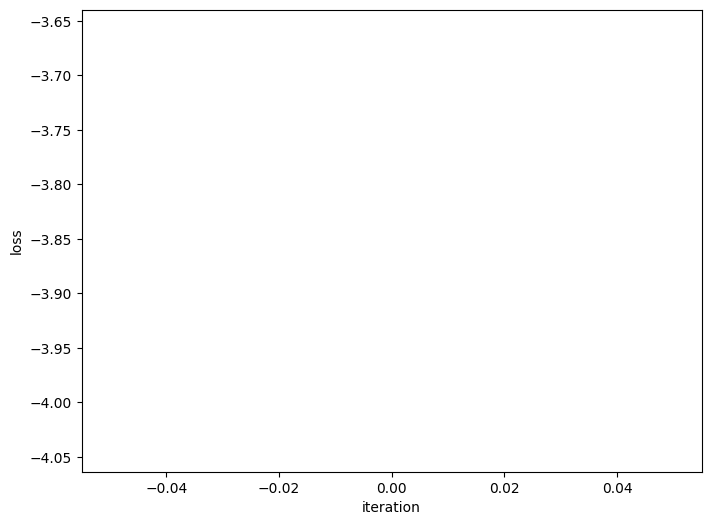

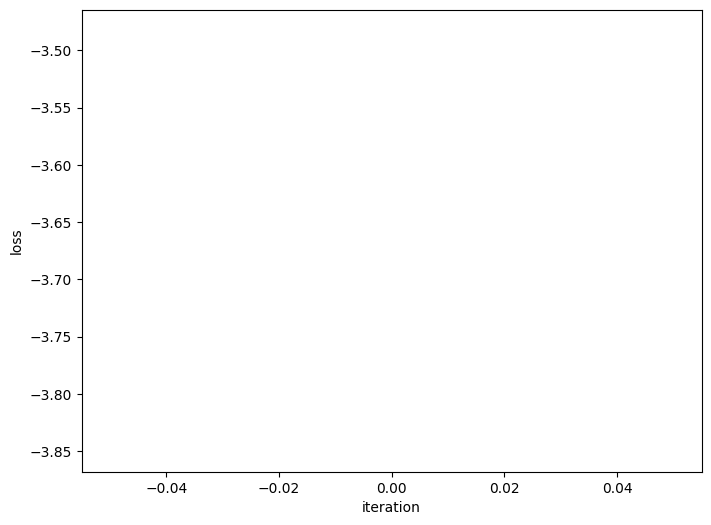

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -715.71103  validloss -731.36587±0.00000  bestvalidloss -731.36587  last_update 0
train: iter 1  trainloss -720.21196  validloss -698.03828±0.00000  bestvalidloss -731.36587  last_update 1
train: iter 2  trainloss -701.88464  validloss -748.90041±0.00000  bestvalidloss -748.90041  last_update 0
train: iter 3  trainloss -706.88882  validloss -595.15316±0.00000  bestvalidloss -748.90041  last_update 1
train: iter 4  trainloss -734.65101  validloss -746.16055±0.00000  bestvalidloss -748.90041  last_update 2
train: iter 5  trainloss -727.57138  validloss -687.80040±0.00000  bestvalidloss -748.90041  last_update 3
train: iter 6  trainloss -729.57028  validloss -698.67012±0.00000  bestvalidloss -748.90041  last_update 4
train: iter 7  trainloss -721.32762  validloss -740.96740±0.00000  bestvalidloss -748.90041  last_update 5
train: iter 8  trainloss -713.98271  validloss -687.73674±0.00000  bestvalidloss -748.90041  last_u

train: iter 76  trainloss -750.98026  validloss -719.03057±0.00000  bestvalidloss -769.05884  last_update 8
train: iter 77  trainloss -750.85157  validloss -754.55866±0.00000  bestvalidloss -769.05884  last_update 9
train: iter 78  trainloss -758.31460  validloss -755.53485±0.00000  bestvalidloss -769.05884  last_update 10
train: iter 79  trainloss -756.05046  validloss -744.37133±0.00000  bestvalidloss -769.05884  last_update 11
train: iter 80  trainloss -758.65202  validloss -707.00053±0.00000  bestvalidloss -769.05884  last_update 12
train: iter 81  trainloss -745.03112  validloss -752.56287±0.00000  bestvalidloss -769.05884  last_update 13
train: iter 82  trainloss -753.94346  validloss -745.66303±0.00000  bestvalidloss -769.05884  last_update 14
train: iter 83  trainloss -760.94771  validloss -730.88061±0.00000  bestvalidloss -769.05884  last_update 15
train: iter 84  trainloss -766.85586  validloss -746.00845±0.00000  bestvalidloss -769.05884  last_update 16
train: iter 85  train

train: iter 151  trainloss -772.21816  validloss -715.83705±0.00000  bestvalidloss -794.38247  last_update 24
train: iter 152  trainloss -763.48074  validloss -729.39500±0.00000  bestvalidloss -794.38247  last_update 25
train: iter 153  trainloss -782.90256  validloss -715.03810±0.00000  bestvalidloss -794.38247  last_update 26
train: iter 154  trainloss -777.24872  validloss -761.82812±0.00000  bestvalidloss -794.38247  last_update 27
train: iter 155  trainloss -777.89513  validloss -749.25585±0.00000  bestvalidloss -794.38247  last_update 28
train: iter 156  trainloss -763.53106  validloss -773.19582±0.00000  bestvalidloss -794.38247  last_update 29
train: iter 157  trainloss -780.83712  validloss -767.14150±0.00000  bestvalidloss -794.38247  last_update 30
train: iter 158  trainloss -789.62321  validloss -776.13554±0.00000  bestvalidloss -794.38247  last_update 31
train: iter 159  trainloss -776.85056  validloss -805.47856±0.00000  bestvalidloss -805.47856  last_update 0
train: iter

train: iter 226  trainloss -799.83651  validloss -785.58719±0.00000  bestvalidloss -805.47856  last_update 67
train: iter 227  trainloss -795.33821  validloss -775.86638±0.00000  bestvalidloss -805.47856  last_update 68
train: iter 228  trainloss -783.50436  validloss -763.56327±0.00000  bestvalidloss -805.47856  last_update 69
train: iter 229  trainloss -814.00115  validloss -804.77655±0.00000  bestvalidloss -805.47856  last_update 70
train: iter 230  trainloss -795.09588  validloss -798.52865±0.00000  bestvalidloss -805.47856  last_update 71
train: iter 231  trainloss -806.32498  validloss -795.23774±0.00000  bestvalidloss -805.47856  last_update 72
train: iter 232  trainloss -817.05342  validloss -785.35007±0.00000  bestvalidloss -805.47856  last_update 73
train: iter 233  trainloss -777.08116  validloss -759.43461±0.00000  bestvalidloss -805.47856  last_update 74
train: iter 234  trainloss -792.90432  validloss -716.21795±0.00000  bestvalidloss -805.47856  last_update 75
train: ite

train: iter 301  trainloss -735.89097  validloss -748.63385±0.00000  bestvalidloss -812.28319  last_update 62
train: iter 302  trainloss -753.03104  validloss -760.62989±0.00000  bestvalidloss -812.28319  last_update 63
train: iter 303  trainloss -734.70541  validloss -763.91843±0.00000  bestvalidloss -812.28319  last_update 64
train: iter 304  trainloss -739.93054  validloss -713.56825±0.00000  bestvalidloss -812.28319  last_update 65
train: iter 305  trainloss -757.77982  validloss -761.02555±0.00000  bestvalidloss -812.28319  last_update 66
train: iter 306  trainloss -755.94787  validloss -763.54718±0.00000  bestvalidloss -812.28319  last_update 67
train: iter 307  trainloss -758.61863  validloss -763.98715±0.00000  bestvalidloss -812.28319  last_update 68
train: iter 308  trainloss -739.66526  validloss -758.96220±0.00000  bestvalidloss -812.28319  last_update 69
train: iter 309  trainloss -744.46971  validloss -740.06026±0.00000  bestvalidloss -812.28319  last_update 70
train: ite

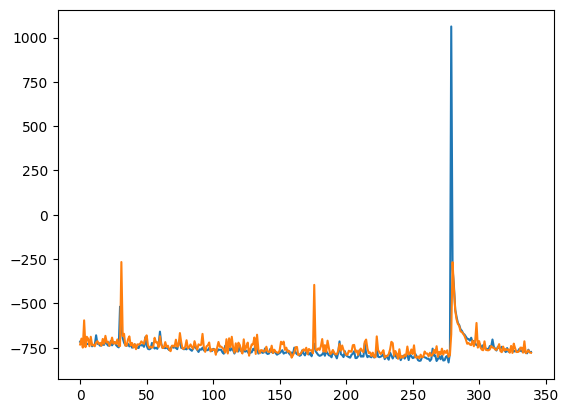

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-28 23:41:16.744946


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [ -23.04833178 -139.3522472   -52.57807028  -24.14817195] [   0.28080891 -145.46763122   -1.53639625    4.76453659] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 112
predict diverge [-20.96551471  -7.60451747 -21.28127216 -37.26244908] [ -0.25441417  -2.50359304  -1.02623517 -15.35191921] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 81

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17
predict diverge [ -7.08500551  61.49997516 -44.70644865 -17.00572639] [ 0.66501065 48.22211018 -1.17066598  5.38186802] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 134

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [-20.1185525  -45.54565446 -36.61542919 -31.96127506] [ -0.17756793 -42.56168769  -1.28047806  -5.80636983] [123.31068   20.796759 186.59457   34.53283 ] [61.65534 

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.52940  validloss 5.64918±0.00000  bestvalidloss 5.64918  last_update 0
train: iter 1  trainloss 0.55022  validloss 0.95048±0.00000  bestvalidloss 0.95048  last_update 0
train: iter 2  trainloss 0.51019  validloss 0.83885±0.00000  bestvalidloss 0.83885  last_update 0
train: iter 3  trainloss 0.49217  validloss 0.80244±0.00000  bestvalidloss 0.80244  last_update 0
train: iter 4  trainloss 0.47496  validloss 0.73672±0.00000  bestvalidloss 0.73672  last_update 0
train: iter 5  trainloss 0.46187  validloss 0.69687±0.00000  bestvalidloss 0.69687  last_update 0
train: iter 6  trainloss 0.44596  validloss 0.63977±0.00000  bestvalidloss 0.63977  last_update 0
train: iter 7  trainloss 0.43892  validloss 0.59143±0.00000  bestvalidloss 0.59143  last_update 0
train: iter 8  trainloss 0.43058  validloss 0.56799±0.00000  bestvalidloss 0.56799  last_update 0
train: iter 9  trainloss 0.42510  validloss 0.57536±0.00000  bestvalidloss 0.56799  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.33656  validloss 0.44036±0.00000  bestvalidloss 0.43267  last_update 10
train: iter 84  trainloss 0.33970  validloss 0.44570±0.00000  bestvalidloss 0.43267  last_update 11
train: iter 85  trainloss 0.33953  validloss 0.43725±0.00000  bestvalidloss 0.43267  last_update 12
train: iter 86  trainloss 0.34221  validloss 0.44317±0.00000  bestvalidloss 0.43267  last_update 13
train: iter 87  trainloss 0.33781  validloss 0.44207±0.00000  bestvalidloss 0.43267  last_update 14
train: iter 88  trainloss 0.33547  validloss 0.43488±0.00000  bestvalidloss 0.43267  last_update 15
train: iter 89  trainloss 0.33920  validloss 0.43303±0.00000  bestvalidloss 0.43267  last_update 16
train: iter 90  trainloss 0.34039  validloss 0.44161±0.00000  bestvalidloss 0.43267  last_update 17
train: iter 91  trainloss 0.34140  validloss 0.44207±0.00000  bestvalidloss 0.43267  last_update 18
train: iter 92  trainloss 0.33759  validloss 0.44220±0.00000  bestvalidloss 0.43267  last_update 19


train: iter 165  trainloss 0.32208  validloss 0.44436±0.00000  bestvalidloss 0.43093  last_update 72
train: iter 166  trainloss 0.32320  validloss 0.43975±0.00000  bestvalidloss 0.43093  last_update 73
train: iter 167  trainloss 0.32095  validloss 0.43877±0.00000  bestvalidloss 0.43093  last_update 74
train: iter 168  trainloss 0.31927  validloss 0.44239±0.00000  bestvalidloss 0.43093  last_update 75
train: iter 169  trainloss 0.31788  validloss 0.44434±0.00000  bestvalidloss 0.43093  last_update 76
train: iter 170  trainloss 0.32151  validloss 0.43973±0.00000  bestvalidloss 0.43093  last_update 77
train: iter 171  trainloss 0.31919  validloss 0.43848±0.00000  bestvalidloss 0.43093  last_update 78
train: iter 172  trainloss 0.32963  validloss 0.44174±0.00000  bestvalidloss 0.43093  last_update 79
train: iter 173  trainloss 0.31747  validloss 0.43575±0.00000  bestvalidloss 0.43093  last_update 80
train: iter 174  trainloss 0.32028  validloss 0.45073±0.00000  bestvalidloss 0.43093  last_

train_loss:  -3.88326531484127
valid_loss:  -6.571430579185486
weight_alpha 1.0 h_min_tilde -11.606369 ell_tilde -4.420898367710113 kappa_tilde 0.0003730545919198703
train_loss:  -3.901243221569061
valid_loss:  -3.834627359199524
weight_alpha 0.1 h_min_tilde -11.606369 ell_tilde -3.8879200490951535 kappa_tilde 0.0003599440354932622


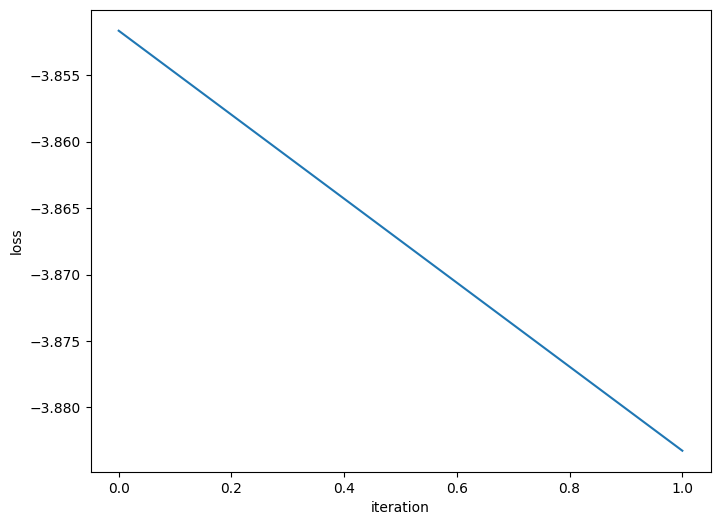

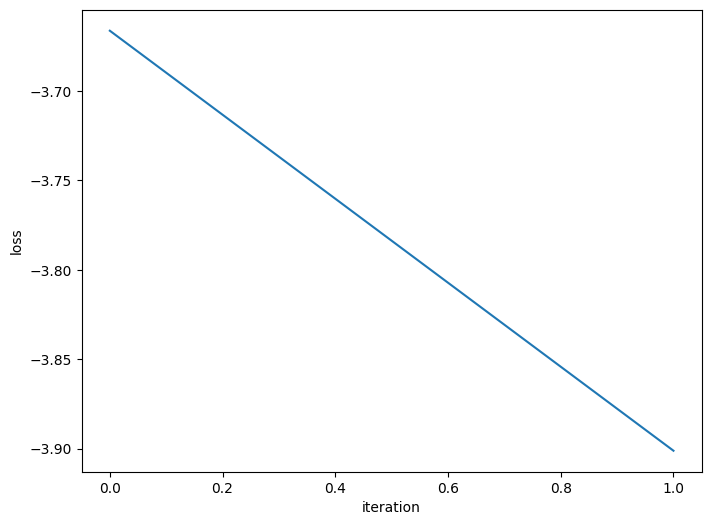

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -707.33931  validloss -766.04286±0.00000  bestvalidloss -766.04286  last_update 0
train: iter 1  trainloss -743.32496  validloss -605.60894±0.00000  bestvalidloss -766.04286  last_update 1
train: iter 2  trainloss -782.40088  validloss -714.98295±0.00000  bestvalidloss -766.04286  last_update 2
train: iter 3  trainloss -789.32663  validloss -777.57855±0.00000  bestvalidloss -777.57855  last_update 0
train: iter 4  trainloss -751.07354  validloss -606.47497±0.00000  bestvalidloss -777.57855  last_update 1
train: iter 5  trainloss -784.96261  validloss -757.38563±0.00000  bestvalidloss -777.57855  last_update 2
train: iter 6  trainloss -754.27699  validloss -754.07803±0.00000  bestvalidloss -777.57855  last_update 3
train: iter 7  trainloss -725.45113  validloss -376.64663±0.00000  bestvalidloss -777.57855  last_update 4
train: iter 8  trainloss -778.48473  validloss -723.30856±0.00000  bestvalidloss -777.57855  last_u

train: iter 76  trainloss -729.08930  validloss -738.31571±0.00000  bestvalidloss -801.55553  last_update 16
train: iter 77  trainloss -701.32939  validloss -734.42448±0.00000  bestvalidloss -801.55553  last_update 17
train: iter 78  trainloss -750.00320  validloss -752.58780±0.00000  bestvalidloss -801.55553  last_update 18
train: iter 79  trainloss -758.89380  validloss -767.69694±0.00000  bestvalidloss -801.55553  last_update 19
train: iter 80  trainloss -769.87587  validloss -761.61952±0.00000  bestvalidloss -801.55553  last_update 20
train: iter 81  trainloss -724.03406  validloss -749.50182±0.00000  bestvalidloss -801.55553  last_update 21
train: iter 82  trainloss -765.02891  validloss -685.84896±0.00000  bestvalidloss -801.55553  last_update 22
train: iter 83  trainloss -770.85206  validloss -745.62834±0.00000  bestvalidloss -801.55553  last_update 23
train: iter 84  trainloss -781.72765  validloss -727.97911±0.00000  bestvalidloss -801.55553  last_update 24
train: iter 85  tra

train: iter 151  trainloss -798.35337  validloss -708.53077±0.00000  bestvalidloss -801.55553  last_update 91
train: iter 152  trainloss -812.28381  validloss -741.42274±0.00000  bestvalidloss -801.55553  last_update 92
train: iter 153  trainloss -802.26564  validloss -737.12772±0.00000  bestvalidloss -801.55553  last_update 93
train: iter 154  trainloss -805.80455  validloss -717.67411±0.00000  bestvalidloss -801.55553  last_update 94
train: iter 155  trainloss -761.34974  validloss -735.11501±0.00000  bestvalidloss -801.55553  last_update 95
train: iter 156  trainloss -793.92829  validloss -745.49510±0.00000  bestvalidloss -801.55553  last_update 96
train: iter 157  trainloss -819.83294  validloss -798.37447±0.00000  bestvalidloss -801.55553  last_update 97
train: iter 158  trainloss -821.56122  validloss -774.67213±0.00000  bestvalidloss -801.55553  last_update 98
train: iter 159  trainloss -803.75507  validloss -782.88437±0.00000  bestvalidloss -801.55553  last_update 99
train: ite

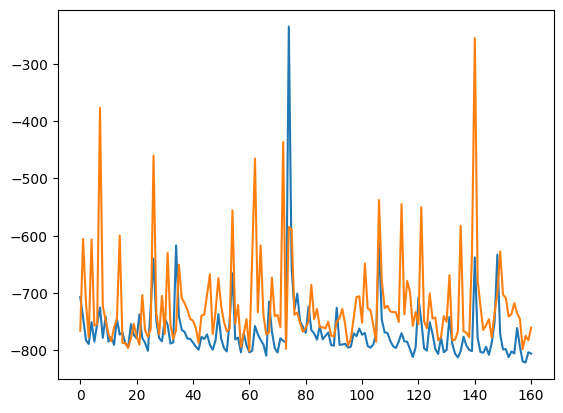

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-29 00:07:17.887008


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25
predict diverge [-42.81354769 240.30941661 -32.19135787 -12.38876622] [  0.75492602 226.39340614  -1.61187261  20.23648517] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 166
predict diverge [-53.87692415  21.07632427 -36.55251229 -25.39801266] [ 0.4677164  14.29645746 -1.21020769 -3.57288647] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 189

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53
predict diverge [-41.60116414 -17.98374263 -37.10550729 -34.89124004] [-0.66072187 -1.78907092 -1.50647998 -4.62564983] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 176

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65



In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.41822  validloss 0.53963±0.00000  bestvalidloss 0.53963  last_update 0
train: iter 1  trainloss 0.40217  validloss 0.52256±0.00000  bestvalidloss 0.52256  last_update 0
train: iter 2  trainloss 0.39034  validloss 0.51813±0.00000  bestvalidloss 0.51813  last_update 0
train: iter 3  trainloss 0.39224  validloss 0.51255±0.00000  bestvalidloss 0.51255  last_update 0
train: iter 4  trainloss 0.38856  validloss 0.51610±0.00000  bestvalidloss 0.51255  last_update 1
train: iter 5  trainloss 0.38180  validloss 0.52146±0.00000  bestvalidloss 0.51255  last_update 2
train: iter 6  trainloss 0.38488  validloss 0.50782±0.00000  bestvalidloss 0.50782  last_update 0
train: iter 7  trainloss 0.38273  validloss 0.52422±0.00000  bestvalidloss 0.50782  last_update 1
train: iter 8  trainloss 0.37724  validloss 0.53515±0.00000  bestvalidloss 0.50782  last_update 2
train: iter 9  trainloss 0.37887  validloss 0.52267±0.00000  bestvalidloss 0.50782  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.34376  validloss 0.51617±0.00000  bestvalidloss 0.50571  last_update 30
train: iter 84  trainloss 0.34591  validloss 0.52218±0.00000  bestvalidloss 0.50571  last_update 31
train: iter 85  trainloss 0.34442  validloss 0.51539±0.00000  bestvalidloss 0.50571  last_update 32
train: iter 86  trainloss 0.34283  validloss 0.53981±0.00000  bestvalidloss 0.50571  last_update 33
train: iter 87  trainloss 0.34992  validloss 0.52065±0.00000  bestvalidloss 0.50571  last_update 34
train: iter 88  trainloss 0.34484  validloss 0.52466±0.00000  bestvalidloss 0.50571  last_update 35
train: iter 89  trainloss 0.34164  validloss 0.52357±0.00000  bestvalidloss 0.50571  last_update 36
train: iter 90  trainloss 0.34623  validloss 0.52623±0.00000  bestvalidloss 0.50571  last_update 37
train: iter 91  trainloss 0.34542  validloss 0.56685±0.00000  bestvalidloss 0.50571  last_update 38
train: iter 92  trainloss 0.34431  validloss 0.50925±0.00000  bestvalidloss 0.50571  last_update 39


train: iter 165  trainloss 0.32996  validloss 0.50276±0.00000  bestvalidloss 0.49650  last_update 35
train: iter 166  trainloss 0.32855  validloss 0.50522±0.00000  bestvalidloss 0.49650  last_update 36
train: iter 167  trainloss 0.32690  validloss 0.52576±0.00000  bestvalidloss 0.49650  last_update 37
train: iter 168  trainloss 0.32835  validloss 0.50668±0.00000  bestvalidloss 0.49650  last_update 38
train: iter 169  trainloss 0.33229  validloss 0.51629±0.00000  bestvalidloss 0.49650  last_update 39
train: iter 170  trainloss 0.33271  validloss 0.53039±0.00000  bestvalidloss 0.49650  last_update 40
train: iter 171  trainloss 0.33021  validloss 0.51882±0.00000  bestvalidloss 0.49650  last_update 41
train: iter 172  trainloss 0.32990  validloss 0.51937±0.00000  bestvalidloss 0.49650  last_update 42
train: iter 173  trainloss 0.33057  validloss 0.51479±0.00000  bestvalidloss 0.49650  last_update 43
train: iter 174  trainloss 0.33371  validloss 0.50711±0.00000  bestvalidloss 0.49650  last_

train: iter 247  trainloss 0.31905  validloss 0.51126±0.00000  bestvalidloss 0.49619  last_update 26
train: iter 248  trainloss 0.32307  validloss 0.53380±0.00000  bestvalidloss 0.49619  last_update 27
train: iter 249  trainloss 0.32455  validloss 0.51739±0.00000  bestvalidloss 0.49619  last_update 28
train: iter 250  trainloss 0.32020  validloss 0.51499±0.00000  bestvalidloss 0.49619  last_update 29
train: iter 251  trainloss 0.32387  validloss 0.51158±0.00000  bestvalidloss 0.49619  last_update 30
train: iter 252  trainloss 0.31741  validloss 0.50829±0.00000  bestvalidloss 0.49619  last_update 31
train: iter 253  trainloss 0.32173  validloss 0.54908±0.00000  bestvalidloss 0.49619  last_update 32
train: iter 254  trainloss 0.31804  validloss 0.50205±0.00000  bestvalidloss 0.49619  last_update 33
train: iter 255  trainloss 0.31841  validloss 0.50483±0.00000  bestvalidloss 0.49619  last_update 34
train: iter 256  trainloss 0.32075  validloss 0.51222±0.00000  bestvalidloss 0.49619  last_

train: iter 329  trainloss 0.31355  validloss 0.53728±0.00000  bestvalidloss 0.49482  last_update 15
train: iter 330  trainloss 0.31545  validloss 0.52181±0.00000  bestvalidloss 0.49482  last_update 16
train: iter 331  trainloss 0.31212  validloss 0.51691±0.00000  bestvalidloss 0.49482  last_update 17
train: iter 332  trainloss 0.31332  validloss 0.51494±0.00000  bestvalidloss 0.49482  last_update 18
train: iter 333  trainloss 0.31312  validloss 0.51534±0.00000  bestvalidloss 0.49482  last_update 19
train: iter 334  trainloss 0.31165  validloss 0.51794±0.00000  bestvalidloss 0.49482  last_update 20
train: iter 335  trainloss 0.30890  validloss 0.50413±0.00000  bestvalidloss 0.49482  last_update 21
train: iter 336  trainloss 0.31487  validloss 0.50989±0.00000  bestvalidloss 0.49482  last_update 22
train: iter 337  trainloss 0.31201  validloss 0.53634±0.00000  bestvalidloss 0.49482  last_update 23
train: iter 338  trainloss 0.31162  validloss 0.51439±0.00000  bestvalidloss 0.49482  last_

train: iter 411  trainloss 0.30654  validloss 0.52982±0.00000  bestvalidloss 0.49482  last_update 97
train: iter 412  trainloss 0.30443  validloss 0.51301±0.00000  bestvalidloss 0.49482  last_update 98
train: iter 413  trainloss 0.30686  validloss 0.51669±0.00000  bestvalidloss 0.49482  last_update 99
train: iter 414  trainloss 0.30948  validloss 0.51492±0.00000  bestvalidloss 0.49482  last_update 100
train: fin


train_loss:  -4.403427785277366
valid_loss:  -7.378879015731814
weight_alpha 1.0 h_min_tilde -11.783809 ell_tilde -4.998518031368255 kappa_tilde 0.0003838979308781731
train_loss:  -3.8579429315090175
valid_loss:  -3.9010549358367923
weight_alpha 0.1 h_min_tilde -11.783809 ell_tilde -3.866565332374572 kappa_tilde 0.000355396382027285


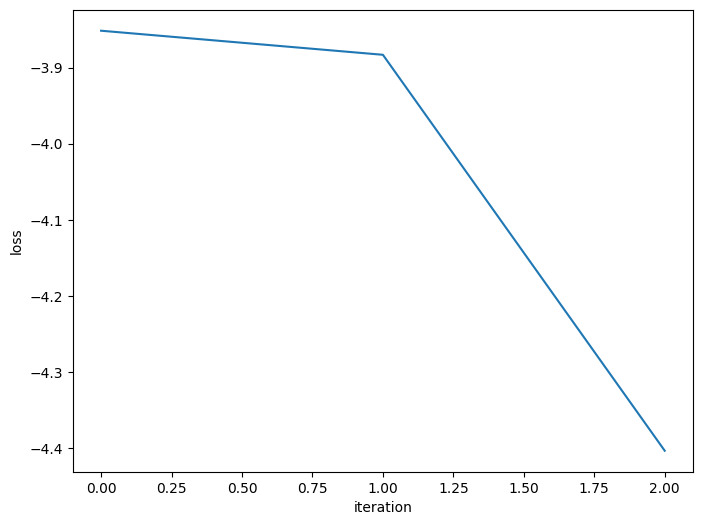

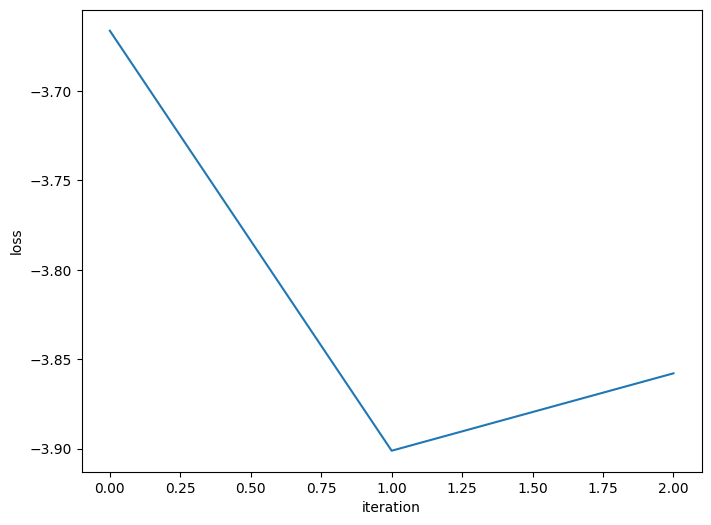

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -766.71864  validloss -781.27561±0.00000  bestvalidloss -781.27561  last_update 0
train: iter 1  trainloss -777.11022  validloss -807.09168±0.00000  bestvalidloss -807.09168  last_update 0
train: iter 2  trainloss -719.12031  validloss -350.72695±0.00000  bestvalidloss -807.09168  last_update 1
train: iter 3  trainloss -760.34164  validloss -557.85168±0.00000  bestvalidloss -807.09168  last_update 2
train: iter 4  trainloss -777.47836  validloss -782.90347±0.00000  bestvalidloss -807.09168  last_update 3
train: iter 5  trainloss -769.86721  validloss -798.36892±0.00000  bestvalidloss -807.09168  last_update 4
train: iter 6  trainloss -779.38742  validloss -803.24065±0.00000  bestvalidloss -807.09168  last_update 5
train: iter 7  trainloss -746.56922  validloss -783.08603±0.00000  bestvalidloss -807.09168  last_update 6
train: iter 8  trainloss -773.78246  validloss -678.53668±0.00000  bestvalidloss -807.09168  last_u

train: iter 76  trainloss -759.14883  validloss -770.46381±0.00000  bestvalidloss -823.62400  last_update 14
train: iter 77  trainloss -784.96507  validloss -734.58646±0.00000  bestvalidloss -823.62400  last_update 15
train: iter 78  trainloss -760.26207  validloss -774.26626±0.00000  bestvalidloss -823.62400  last_update 16
train: iter 79  trainloss -787.99445  validloss -757.97508±0.00000  bestvalidloss -823.62400  last_update 17
train: iter 80  trainloss -789.35762  validloss -786.73555±0.00000  bestvalidloss -823.62400  last_update 18
train: iter 81  trainloss -792.83397  validloss -809.08046±0.00000  bestvalidloss -823.62400  last_update 19
train: iter 82  trainloss -784.96464  validloss -797.35623±0.00000  bestvalidloss -823.62400  last_update 20
train: iter 83  trainloss -770.85185  validloss -820.88504±0.00000  bestvalidloss -823.62400  last_update 21
train: iter 84  trainloss -732.11854  validloss -635.51364±0.00000  bestvalidloss -823.62400  last_update 22
train: iter 85  tra

train: iter 151  trainloss -807.25819  validloss -768.62909±0.00000  bestvalidloss -836.79170  last_update 8
train: iter 152  trainloss -801.02160  validloss -792.93677±0.00000  bestvalidloss -836.79170  last_update 9
train: iter 153  trainloss -808.31301  validloss -805.21634±0.00000  bestvalidloss -836.79170  last_update 10
train: iter 154  trainloss -790.17245  validloss -796.80574±0.00000  bestvalidloss -836.79170  last_update 11
train: iter 155  trainloss -790.67719  validloss -818.80571±0.00000  bestvalidloss -836.79170  last_update 12
train: iter 156  trainloss -783.68481  validloss -773.92160±0.00000  bestvalidloss -836.79170  last_update 13
train: iter 157  trainloss -801.85533  validloss -784.70432±0.00000  bestvalidloss -836.79170  last_update 14
train: iter 158  trainloss -787.34004  validloss -797.88038±0.00000  bestvalidloss -836.79170  last_update 15
train: iter 159  trainloss -805.77064  validloss -797.20846±0.00000  bestvalidloss -836.79170  last_update 16
train: iter 

train: iter 226  trainloss -807.74827  validloss -842.23472±0.00000  bestvalidloss -842.23472  last_update 0
train: iter 227  trainloss -811.41722  validloss -693.10098±0.00000  bestvalidloss -842.23472  last_update 1
train: iter 228  trainloss -807.96233  validloss -733.21027±0.00000  bestvalidloss -842.23472  last_update 2
train: iter 229  trainloss -803.91089  validloss -768.69009±0.00000  bestvalidloss -842.23472  last_update 3
train: iter 230  trainloss -783.71561  validloss -808.18934±0.00000  bestvalidloss -842.23472  last_update 4
train: iter 231  trainloss -676.19907  validloss -702.71402±0.00000  bestvalidloss -842.23472  last_update 5
train: iter 232  trainloss -743.48565  validloss -706.65943±0.00000  bestvalidloss -842.23472  last_update 6
train: iter 233  trainloss -772.05384  validloss -728.01434±0.00000  bestvalidloss -842.23472  last_update 7
train: iter 234  trainloss -800.37832  validloss -787.31432±0.00000  bestvalidloss -842.23472  last_update 8
train: iter 235  tr

train: iter 301  trainloss -812.16272  validloss -758.82548±0.00000  bestvalidloss -842.23472  last_update 75
train: iter 302  trainloss -818.69237  validloss -825.26711±0.00000  bestvalidloss -842.23472  last_update 76
train: iter 303  trainloss -833.42018  validloss -820.02336±0.00000  bestvalidloss -842.23472  last_update 77
train: iter 304  trainloss -813.67427  validloss -809.13900±0.00000  bestvalidloss -842.23472  last_update 78
train: iter 305  trainloss -800.73524  validloss -844.13876±0.00000  bestvalidloss -844.13876  last_update 0
train: iter 306  trainloss -803.89155  validloss -749.72482±0.00000  bestvalidloss -844.13876  last_update 1
train: iter 307  trainloss -834.23999  validloss -819.45063±0.00000  bestvalidloss -844.13876  last_update 2
train: iter 308  trainloss -829.24563  validloss -809.33754±0.00000  bestvalidloss -844.13876  last_update 3
train: iter 309  trainloss -820.02188  validloss -819.43365±0.00000  bestvalidloss -844.13876  last_update 4
train: iter 310

train: iter 376  trainloss -815.92690  validloss -796.32067±0.00000  bestvalidloss -844.13876  last_update 71
train: iter 377  trainloss -815.39470  validloss -773.63604±0.00000  bestvalidloss -844.13876  last_update 72
train: iter 378  trainloss -822.93348  validloss -757.43960±0.00000  bestvalidloss -844.13876  last_update 73
train: iter 379  trainloss -828.72843  validloss -767.00300±0.00000  bestvalidloss -844.13876  last_update 74
train: iter 380  trainloss -836.66334  validloss -802.78946±0.00000  bestvalidloss -844.13876  last_update 75
train: iter 381  trainloss -823.32196  validloss -772.76048±0.00000  bestvalidloss -844.13876  last_update 76
train: iter 382  trainloss -811.15821  validloss -761.23320±0.00000  bestvalidloss -844.13876  last_update 77
train: iter 383  trainloss -823.38901  validloss -666.50719±0.00000  bestvalidloss -844.13876  last_update 78
train: iter 384  trainloss -829.60712  validloss -801.25026±0.00000  bestvalidloss -844.13876  last_update 79
train: ite

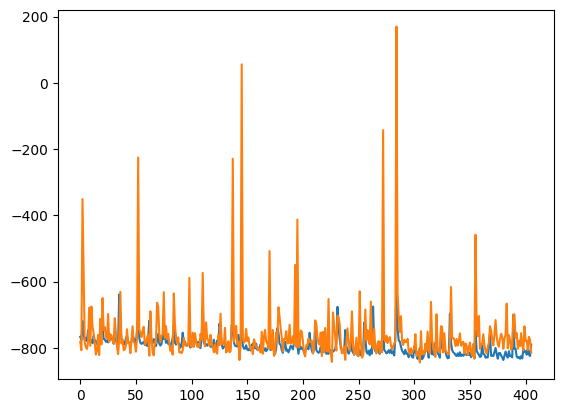

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-29 00:35:21.279816


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-40.61000361 -26.48810311 -16.81505586 -21.53550147] [ -0.10566794 -24.02493834  -1.41401547   7.88476402] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 132

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-35.40235186 -68.74067681 -13.35350205 -28.00006069] [ -0.14634532 -65.61134181  -1.39138822   1.85904449] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 122

 13
predict diverge [-41.69042523 -26.27679747 -40.06227745 -33.80360409] [ -0.66811194 -12.32183482  -1.53641952  -1.66420926] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 159

 14

 15

 16

 17

 18
predict diverge [-33.61909748 -24.38663143 -30.0738113  -55.67100656] [  0.2880686  -31.77113311  -1.49972682 -24.99713055] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 121

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.64297  validloss 1.05271±0.00000  bestvalidloss 1.05271  last_update 0
train: iter 1  trainloss 0.52929  validloss 0.58275±0.00000  bestvalidloss 0.58275  last_update 0
train: iter 2  trainloss 0.50931  validloss 0.55155±0.00000  bestvalidloss 0.55155  last_update 0
train: iter 3  trainloss 0.49681  validloss 0.55076±0.00000  bestvalidloss 0.55076  last_update 0
train: iter 4  trainloss 0.49165  validloss 0.57315±0.00000  bestvalidloss 0.55076  last_update 1
train: iter 5  trainloss 0.48240  validloss 0.57479±0.00000  bestvalidloss 0.55076  last_update 2
train: iter 6  trainloss 0.48134  validloss 0.54289±0.00000  bestvalidloss 0.54289  last_update 0
train: iter 7  trainloss 0.47507  validloss 0.54061±0.00000  bestvalidloss 0.54061  last_update 0
train: iter 8  trainloss 0.47228  validloss 0.53574±0.00000  bestvalidloss 0.53574  last_update 0
train: iter 9  trainloss 0.47270  validloss 0.52808±0.00000  bestvalidloss 0.52808  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41883  validloss 0.54016±0.00000  bestvalidloss 0.50984  last_update 1
train: iter 84  trainloss 0.42278  validloss 0.54921±0.00000  bestvalidloss 0.50984  last_update 2
train: iter 85  trainloss 0.42048  validloss 0.53982±0.00000  bestvalidloss 0.50984  last_update 3
train: iter 86  trainloss 0.42441  validloss 0.54633±0.00000  bestvalidloss 0.50984  last_update 4
train: iter 87  trainloss 0.42044  validloss 0.52379±0.00000  bestvalidloss 0.50984  last_update 5
train: iter 88  trainloss 0.42672  validloss 0.53388±0.00000  bestvalidloss 0.50984  last_update 6
train: iter 89  trainloss 0.42214  validloss 0.52455±0.00000  bestvalidloss 0.50984  last_update 7
train: iter 90  trainloss 0.41630  validloss 0.55369±0.00000  bestvalidloss 0.50984  last_update 8
train: iter 91  trainloss 0.42582  validloss 0.54184±0.00000  bestvalidloss 0.50984  last_update 9
train: iter 92  trainloss 0.41915  validloss 0.51953±0.00000  bestvalidloss 0.50984  last_update 10
train: it

train: iter 165  trainloss 0.40160  validloss 0.53080±0.00000  bestvalidloss 0.50984  last_update 83
train: iter 166  trainloss 0.39944  validloss 0.52255±0.00000  bestvalidloss 0.50984  last_update 84
train: iter 167  trainloss 0.40558  validloss 0.53803±0.00000  bestvalidloss 0.50984  last_update 85
train: iter 168  trainloss 0.40289  validloss 0.54394±0.00000  bestvalidloss 0.50984  last_update 86
train: iter 169  trainloss 0.40175  validloss 0.52437±0.00000  bestvalidloss 0.50984  last_update 87
train: iter 170  trainloss 0.40603  validloss 0.53631±0.00000  bestvalidloss 0.50984  last_update 88
train: iter 171  trainloss 0.40125  validloss 0.55099±0.00000  bestvalidloss 0.50984  last_update 89
train: iter 172  trainloss 0.40290  validloss 0.55516±0.00000  bestvalidloss 0.50984  last_update 90
train: iter 173  trainloss 0.40269  validloss 0.51847±0.00000  bestvalidloss 0.50984  last_update 91
train: iter 174  trainloss 0.39834  validloss 0.52160±0.00000  bestvalidloss 0.50984  last_

train_loss:  -5.369980240675807
valid_loss:  -8.694249290466308
weight_alpha 1.0 h_min_tilde -11.583191 ell_tilde -6.034834050633908 kappa_tilde 0.0004245392091564594
train_loss:  -4.134829192352295
valid_loss:  -4.206846350765227
weight_alpha 0.1 h_min_tilde -11.583191 ell_tilde -4.149232624034881 kappa_tilde 0.0003667667355945678


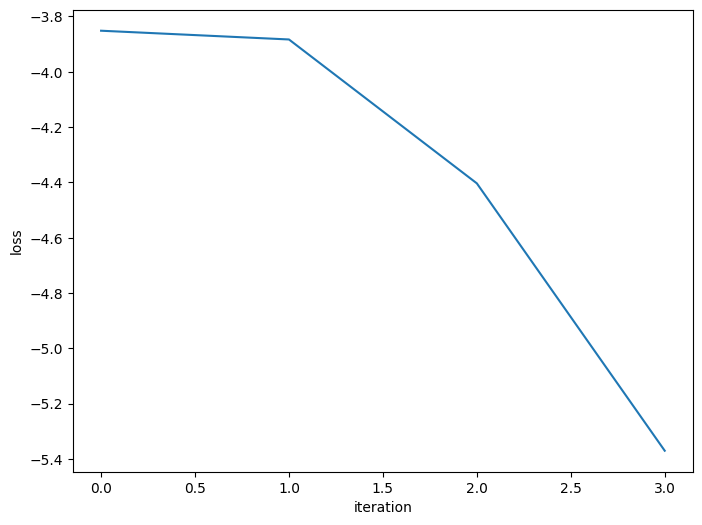

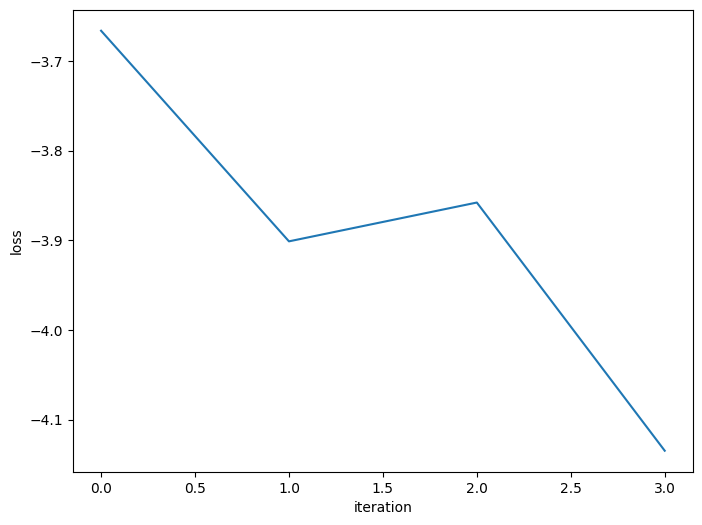

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -885.97569  validloss -839.49368±0.00000  bestvalidloss -839.49368  last_update 0
train: iter 1  trainloss -898.95745  validloss -913.68434±0.00000  bestvalidloss -913.68434  last_update 0
train: iter 2  trainloss -883.92217  validloss -910.65854±0.00000  bestvalidloss -913.68434  last_update 1
train: iter 3  trainloss -863.98109  validloss -882.22033±0.00000  bestvalidloss -913.68434  last_update 2
train: iter 4  trainloss -889.88730  validloss -879.01409±0.00000  bestvalidloss -913.68434  last_update 3
train: iter 5  trainloss -888.52518  validloss -895.71028±0.00000  bestvalidloss -913.68434  last_update 4
train: iter 6  trainloss -903.75029  validloss -894.08158±0.00000  bestvalidloss -913.68434  last_update 5
train: iter 7  trainloss -899.08095  validloss -894.10281±0.00000  bestvalidloss -913.68434  last_update 6
train: iter 8  trainloss -897.79470  validloss -893.22456±0.00000  bestvalidloss -913.68434  last_u

train: iter 76  trainloss -906.25557  validloss -889.54366±0.00000  bestvalidloss -942.06833  last_update 13
train: iter 77  trainloss -909.20346  validloss -913.53791±0.00000  bestvalidloss -942.06833  last_update 14
train: iter 78  trainloss -903.00157  validloss -888.57807±0.00000  bestvalidloss -942.06833  last_update 15
train: iter 79  trainloss -905.02893  validloss -886.46281±0.00000  bestvalidloss -942.06833  last_update 16
train: iter 80  trainloss -907.42239  validloss -867.63147±0.00000  bestvalidloss -942.06833  last_update 17
train: iter 81  trainloss -894.81572  validloss -896.01607±0.00000  bestvalidloss -942.06833  last_update 18
train: iter 82  trainloss -896.62888  validloss -899.10148±0.00000  bestvalidloss -942.06833  last_update 19
train: iter 83  trainloss -903.74751  validloss -904.22423±0.00000  bestvalidloss -942.06833  last_update 20
train: iter 84  trainloss -889.68728  validloss -902.58490±0.00000  bestvalidloss -942.06833  last_update 21
train: iter 85  tra

train: iter 151  trainloss -785.44237  validloss -600.06271±0.00000  bestvalidloss -942.06833  last_update 88
train: iter 152  trainloss -884.02294  validloss -872.75923±0.00000  bestvalidloss -942.06833  last_update 89
train: iter 153  trainloss -899.19503  validloss -890.18901±0.00000  bestvalidloss -942.06833  last_update 90
train: iter 154  trainloss -903.84795  validloss -854.51047±0.00000  bestvalidloss -942.06833  last_update 91
train: iter 155  trainloss -898.96111  validloss -863.03263±0.00000  bestvalidloss -942.06833  last_update 92
train: iter 156  trainloss -904.13754  validloss -876.66407±0.00000  bestvalidloss -942.06833  last_update 93
train: iter 157  trainloss -908.84445  validloss -905.29385±0.00000  bestvalidloss -942.06833  last_update 94
train: iter 158  trainloss -874.65873  validloss -904.44161±0.00000  bestvalidloss -942.06833  last_update 95
train: iter 159  trainloss -899.37541  validloss -862.12641±0.00000  bestvalidloss -942.06833  last_update 96
train: ite

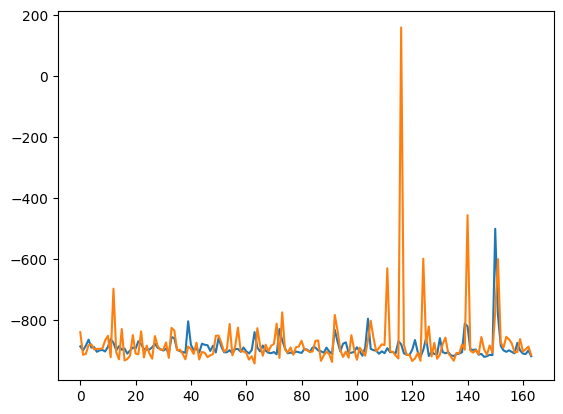

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-29 00:57:29.173767


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4
predict diverge [-50.06093524  25.30095747 -17.79272201 -13.96285114] [-0.12258469 29.45270422 -1.15727529 12.22935566] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 155

 5

 6

 7

 8

 9

 10

 11

 12

 13
predict diverge [-47.12059447 -10.25724223 -28.25991724 -35.52421045] [-0.5643984   4.19177995 -1.36791583 -3.32726821] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 164

 14

 15

 16

 17

 18

 19

 20

 21
predict diverge [-45.00100334 -28.25128313 -27.96002822 -54.17608396] [  0.15598275 -29.98667832  -1.4572925  -21.02051337] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 183

 22
predict diverge [-45.23494685  -2.61286617 -19.68172406 -50.92557316] [ -0.30819377   5.46220096  -1.38036607 -22.88955816] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47899  validloss 0.64820±0.00000  bestvalidloss 0.64820  last_update 0
train: iter 1  trainloss 0.44358  validloss 0.55811±0.00000  bestvalidloss 0.55811  last_update 0
train: iter 2  trainloss 0.43197  validloss 0.54547±0.00000  bestvalidloss 0.54547  last_update 0
train: iter 3  trainloss 0.42786  validloss 0.54561±0.00000  bestvalidloss 0.54547  last_update 1
train: iter 4  trainloss 0.42585  validloss 0.54664±0.00000  bestvalidloss 0.54547  last_update 2
train: iter 5  trainloss 0.42299  validloss 0.55997±0.00000  bestvalidloss 0.54547  last_update 3
train: iter 6  trainloss 0.41800  validloss 0.53476±0.00000  bestvalidloss 0.53476  last_update 0
train: iter 7  trainloss 0.41724  validloss 0.54732±0.00000  bestvalidloss 0.53476  last_update 1
train: iter 8  trainloss 0.42272  validloss 0.52664±0.00000  bestvalidloss 0.52664  last_update 0
train: iter 9  trainloss 0.41426  validloss 0.52597±0.00000  bestvalidloss 0.52597  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.38542  validloss 0.54772±0.00000  bestvalidloss 0.52597  last_update 74
train: iter 84  trainloss 0.38109  validloss 0.54184±0.00000  bestvalidloss 0.52597  last_update 75
train: iter 85  trainloss 0.38289  validloss 0.55394±0.00000  bestvalidloss 0.52597  last_update 76
train: iter 86  trainloss 0.38639  validloss 0.55135±0.00000  bestvalidloss 0.52597  last_update 77
train: iter 87  trainloss 0.38144  validloss 0.54993±0.00000  bestvalidloss 0.52597  last_update 78
train: iter 88  trainloss 0.38115  validloss 0.54780±0.00000  bestvalidloss 0.52597  last_update 79
train: iter 89  trainloss 0.38423  validloss 0.54641±0.00000  bestvalidloss 0.52597  last_update 80
train: iter 90  trainloss 0.38192  validloss 0.54073±0.00000  bestvalidloss 0.52597  last_update 81
train: iter 91  trainloss 0.38136  validloss 0.54378±0.00000  bestvalidloss 0.52597  last_update 82
train: iter 92  trainloss 0.38414  validloss 0.54346±0.00000  bestvalidloss 0.52597  last_update 83


train_loss:  -5.7342011840760705
valid_loss:  -9.31491187801361
weight_alpha 1.0 h_min_tilde -12.191015 ell_tilde -6.450343322863579 kappa_tilde 0.00041736750789518346
train_loss:  -4.329535966205596
valid_loss:  -4.298153383541107
weight_alpha 0.1 h_min_tilde -12.191015 ell_tilde -4.323259449672698 kappa_tilde 0.00035651233798394185


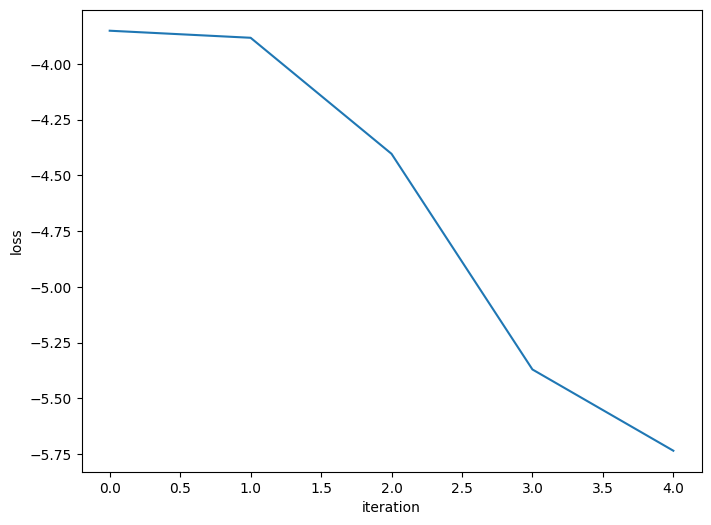

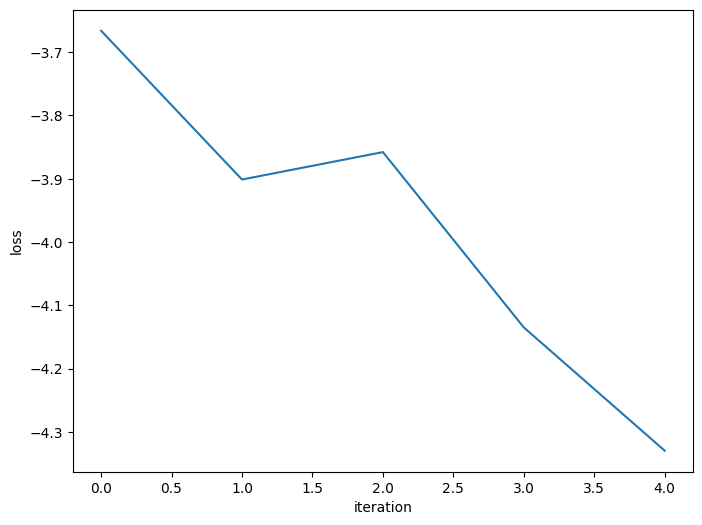

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -855.95481  validloss -861.15574±0.00000  bestvalidloss -861.15574  last_update 0
train: iter 1  trainloss -862.76948  validloss -875.50471±0.00000  bestvalidloss -875.50471  last_update 0
train: iter 2  trainloss -868.75386  validloss -853.98471±0.00000  bestvalidloss -875.50471  last_update 1
train: iter 3  trainloss -853.66062  validloss -853.55231±0.00000  bestvalidloss -875.50471  last_update 2
train: iter 4  trainloss -872.16332  validloss -869.71808±0.00000  bestvalidloss -875.50471  last_update 3
train: iter 5  trainloss -862.22302  validloss -825.26944±0.00000  bestvalidloss -875.50471  last_update 4
train: iter 6  trainloss -822.77751  validloss -867.77704±0.00000  bestvalidloss -875.50471  last_update 5
train: iter 7  trainloss -861.35091  validloss -833.41681±0.00000  bestvalidloss -875.50471  last_update 6
train: iter 8  trainloss -853.89802  validloss -878.89804±0.00000  bestvalidloss -878.89804  last_u

train: iter 76  trainloss -866.44496  validloss -884.37482±0.00000  bestvalidloss -901.94463  last_update 6
train: iter 77  trainloss -868.58310  validloss -896.47895±0.00000  bestvalidloss -901.94463  last_update 7
train: iter 78  trainloss -864.44921  validloss -879.43019±0.00000  bestvalidloss -901.94463  last_update 8
train: iter 79  trainloss -793.42241  validloss -882.64669±0.00000  bestvalidloss -901.94463  last_update 9
train: iter 80  trainloss -830.97537  validloss -802.79200±0.00000  bestvalidloss -901.94463  last_update 10
train: iter 81  trainloss -865.04413  validloss -838.26132±0.00000  bestvalidloss -901.94463  last_update 11
train: iter 82  trainloss -864.86135  validloss -862.52648±0.00000  bestvalidloss -901.94463  last_update 12
train: iter 83  trainloss -807.75243  validloss -888.90152±0.00000  bestvalidloss -901.94463  last_update 13
train: iter 84  trainloss -805.21488  validloss -523.74153±0.00000  bestvalidloss -901.94463  last_update 14
train: iter 85  trainlo

train: iter 151  trainloss -866.71024  validloss -863.48231±0.00000  bestvalidloss -910.19774  last_update 25
train: iter 152  trainloss -873.64291  validloss -848.28385±0.00000  bestvalidloss -910.19774  last_update 26
train: iter 153  trainloss -872.42777  validloss -70.27324±0.00000  bestvalidloss -910.19774  last_update 27
train: iter 154  trainloss -877.08514  validloss -875.71952±0.00000  bestvalidloss -910.19774  last_update 28
train: iter 155  trainloss -858.43904  validloss -840.53157±0.00000  bestvalidloss -910.19774  last_update 29
train: iter 156  trainloss -878.99585  validloss -875.59480±0.00000  bestvalidloss -910.19774  last_update 30
train: iter 157  trainloss -864.54924  validloss -872.30480±0.00000  bestvalidloss -910.19774  last_update 31
train: iter 158  trainloss -862.72782  validloss -841.28257±0.00000  bestvalidloss -910.19774  last_update 32
train: iter 159  trainloss -849.04819  validloss -886.06300±0.00000  bestvalidloss -910.19774  last_update 33
train: iter

train: iter 226  trainloss -856.25302  validloss -875.75829±0.00000  bestvalidloss -910.19774  last_update 100
train: fin
penalty_target_min tensor(-12.0221) penalty_target_max tensor(31.5053)


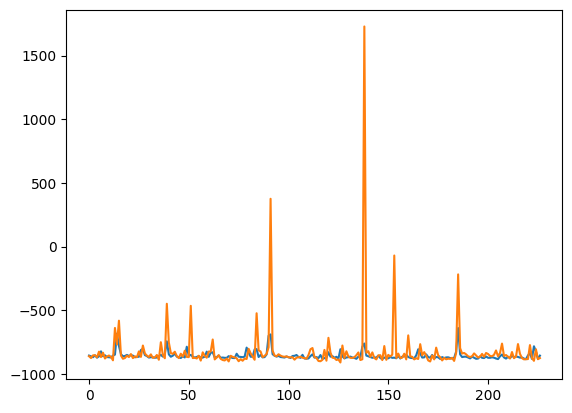

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-29 01:22:36.707060


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-15.17602511 -21.84989712 -30.81028297 -34.77691026] [-0.69279762 -2.91476993 -1.77244668 -3.5144317 ] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 72

 2

 3
predict diverge [-53.67729397 -23.38101097 -26.04205684 -19.80765314] [-0.85533907 -3.68680051 -1.29372493  0.50962455] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 122

 4
predict diverge [-34.67177758  -7.82815375 -11.18561524 -37.09747216] [ -0.43237208   2.19119774  -1.32762994 -12.80464088] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 106

 5

 6

 7
predict diverge [-22.67036057 102.64402769 -42.60540831 -27.5349555 ] [ -0.35231538 105.47808305  -1.84437936   1.31396494] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 105

 8

 9

 10
predict diverge [ -31.00250829 -127.20265997  -1

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47453  validloss 0.62205±0.00000  bestvalidloss 0.62205  last_update 0
train: iter 1  trainloss 0.45263  validloss 0.54863±0.00000  bestvalidloss 0.54863  last_update 0
train: iter 2  trainloss 0.44113  validloss 0.55375±0.00000  bestvalidloss 0.54863  last_update 1
train: iter 3  trainloss 0.43496  validloss 0.55299±0.00000  bestvalidloss 0.54863  last_update 2
train: iter 4  trainloss 0.43986  validloss 0.57886±0.00000  bestvalidloss 0.54863  last_update 3
train: iter 5  trainloss 0.43438  validloss 0.55168±0.00000  bestvalidloss 0.54863  last_update 4
train: iter 6  trainloss 0.42755  validloss 0.54686±0.00000  bestvalidloss 0.54686  last_update 0
train: iter 7  trainloss 0.42861  validloss 0.54988±0.00000  bestvalidloss 0.54686  last_update 1
train: iter 8  trainloss 0.42664  validloss 0.55154±0.00000  bestvalidloss 0.54686  last_update 2
train: iter 9  trainloss 0.42426  validloss 0.54573±0.00000  bestvalidloss 0.54573  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.40671  validloss 0.55333±0.00000  bestvalidloss 0.54135  last_update 20
train: iter 84  trainloss 0.40743  validloss 0.55039±0.00000  bestvalidloss 0.54135  last_update 21
train: iter 85  trainloss 0.40754  validloss 0.54286±0.00000  bestvalidloss 0.54135  last_update 22
train: iter 86  trainloss 0.40118  validloss 0.54840±0.00000  bestvalidloss 0.54135  last_update 23
train: iter 87  trainloss 0.40021  validloss 0.54232±0.00000  bestvalidloss 0.54135  last_update 24
train: iter 88  trainloss 0.39999  validloss 0.54310±0.00000  bestvalidloss 0.54135  last_update 25
train: iter 89  trainloss 0.40309  validloss 0.54472±0.00000  bestvalidloss 0.54135  last_update 26
train: iter 90  trainloss 0.40129  validloss 0.54288±0.00000  bestvalidloss 0.54135  last_update 27
train: iter 91  trainloss 0.40229  validloss 0.54277±0.00000  bestvalidloss 0.54135  last_update 28
train: iter 92  trainloss 0.39785  validloss 0.54272±0.00000  bestvalidloss 0.54135  last_update 29


train: iter 165  trainloss 0.39197  validloss 0.55704±0.00000  bestvalidloss 0.54082  last_update 38
train: iter 166  trainloss 0.39098  validloss 0.54800±0.00000  bestvalidloss 0.54082  last_update 39
train: iter 167  trainloss 0.38990  validloss 0.55237±0.00000  bestvalidloss 0.54082  last_update 40
train: iter 168  trainloss 0.38955  validloss 0.55597±0.00000  bestvalidloss 0.54082  last_update 41
train: iter 169  trainloss 0.39372  validloss 0.54626±0.00000  bestvalidloss 0.54082  last_update 42
train: iter 170  trainloss 0.38910  validloss 0.54465±0.00000  bestvalidloss 0.54082  last_update 43
train: iter 171  trainloss 0.39117  validloss 0.55173±0.00000  bestvalidloss 0.54082  last_update 44
train: iter 172  trainloss 0.39038  validloss 0.54986±0.00000  bestvalidloss 0.54082  last_update 45
train: iter 173  trainloss 0.38704  validloss 0.55152±0.00000  bestvalidloss 0.54082  last_update 46
train: iter 174  trainloss 0.39182  validloss 0.55264±0.00000  bestvalidloss 0.54082  last_

([0.4745288842357695,
  0.4526263171806931,
  0.44112879019230605,
  0.4349569298326969,
  0.43985560443252325,
  0.43438332844525573,
  0.4275515638291836,
  0.4286060524173081,
  0.4266449935734272,
  0.42426438108086584,
  0.42802921403199434,
  0.4336331760510802,
  0.4249195786193013,
  0.4281442303210497,
  0.42970781000331043,
  0.4206079140305519,
  0.42107047364115713,
  0.4195841677486897,
  0.42124740947037936,
  0.41615010127425195,
  0.4203251009806991,
  0.4262878560461104,
  0.4151348563842475,
  0.4121384734287858,
  0.4145601280964911,
  0.41807013656944036,
  0.4201768828555942,
  0.4162112822756171,
  0.41269270367920396,
  0.41509504411369563,
  0.4279752908274531,
  0.4116091100499034,
  0.4153530906885862,
  0.4143056258559227,
  0.4162727173417807,
  0.41332812821492554,
  0.4168562233448029,
  0.4157486448995769,
  0.4113853738643229,
  0.41723090652376416,
  0.41297076027840374,
  0.41478249467909334,
  0.4115763054229319,
  0.4131641953252256,
  0.408574451692

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.957857234445213
valid_loss:  -9.383932865810394
weight_alpha 1.0 h_min_tilde -12.022081 ell_tilde -6.643072360718249 kappa_tilde 0.00043117032575814364
train_loss:  -4.266809070205688
valid_loss:  -4.097672320938111
weight_alpha 0.1 h_min_tilde -12.022081 ell_tilde -4.232981720352172 kappa_tilde 0.000358307888632955


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 34.50059  validloss 38.64461±0.00000  bestvalidloss 38.64461  last_update 0
train: iter 1  trainloss 25.13491  validloss 26.84906±0.00000  bestvalidloss 26.84906  last_update 0
train: iter 2  trainloss 17.92422  validloss 19.27106±0.00000  bestvalidloss 19.27106  last_update 0
train: iter 3  trainloss 13.06379  validloss 13.86254±0.00000  bestvalidloss 13.86254  last_update 0
train: iter 4  trainloss 9.37915  validloss 9.89980±0.00000  bestvalidloss 9.89980  last_update 0
train: iter 5  trainloss 6.99505  validloss 7.05711±0.00000  bestvalidloss 7.05711  last_update 0
train: iter 6  trainloss 4.94410  validloss 4.87066±0.00000  bestvalidloss 4.87066  last_update 0
train: iter 7  trainloss 3.90781  validloss 3.47163±0.00000  bestvalidloss 3.47163  last_update 0
train: iter 8  trainloss 2.64955  validloss 1.96941±0.00000  bestvalidloss 1.96941  last_update 0
train: iter 9  trainloss 2.04378  validloss 1.11669±0.00000  bestvalidloss 1.11669  last_update 0
train: i

train: iter 84  trainloss -1.01148  validloss -1.66768±0.00000  bestvalidloss -1.69638  last_update 2
train: iter 85  trainloss -1.03570  validloss -1.62525±0.00000  bestvalidloss -1.69638  last_update 3
train: iter 86  trainloss -1.05375  validloss -1.62782±0.00000  bestvalidloss -1.69638  last_update 4
train: iter 87  trainloss -0.99858  validloss -1.66698±0.00000  bestvalidloss -1.69638  last_update 5
train: iter 88  trainloss -1.10542  validloss -1.59137±0.00000  bestvalidloss -1.69638  last_update 6
train: iter 89  trainloss -0.99882  validloss -1.63046±0.00000  bestvalidloss -1.69638  last_update 7
train: iter 90  trainloss -1.10731  validloss -1.59856±0.00000  bestvalidloss -1.69638  last_update 8
train: iter 91  trainloss -1.07048  validloss -1.63358±0.00000  bestvalidloss -1.69638  last_update 9
train: iter 92  trainloss -1.06021  validloss -1.71009±0.00000  bestvalidloss -1.71009  last_update 0
train: iter 93  trainloss -1.07302  validloss -1.66636±0.00000  bestvalidloss -1.7

train: iter 170  trainloss -1.08327  validloss -1.64396±0.00000  bestvalidloss -1.72038  last_update 56
train: iter 171  trainloss -1.07893  validloss -1.64274±0.00000  bestvalidloss -1.72038  last_update 57
train: iter 172  trainloss -1.09467  validloss -1.58734±0.00000  bestvalidloss -1.72038  last_update 58
train: iter 173  trainloss -1.13141  validloss -1.68040±0.00000  bestvalidloss -1.72038  last_update 59
train: iter 174  trainloss -1.03422  validloss -1.63685±0.00000  bestvalidloss -1.72038  last_update 60
train: iter 175  trainloss -1.06934  validloss -1.64256±0.00000  bestvalidloss -1.72038  last_update 61
train: iter 176  trainloss -1.11515  validloss -1.60130±0.00000  bestvalidloss -1.72038  last_update 62
train: iter 177  trainloss -1.10632  validloss -1.60059±0.00000  bestvalidloss -1.72038  last_update 63
train: iter 178  trainloss -1.03564  validloss -1.63845±0.00000  bestvalidloss -1.72038  last_update 64
train: iter 179  trainloss -1.10883  validloss -1.62782±0.00000 

train: iter 254  trainloss -1.04370  validloss -1.66161±0.00000  bestvalidloss -1.72208  last_update 66
train: iter 255  trainloss -1.08741  validloss -1.60374±0.00000  bestvalidloss -1.72208  last_update 67
train: iter 256  trainloss -1.08024  validloss -1.60097±0.00000  bestvalidloss -1.72208  last_update 68
train: iter 257  trainloss -1.11873  validloss -1.69580±0.00000  bestvalidloss -1.72208  last_update 69
train: iter 258  trainloss -1.10164  validloss -1.52954±0.00000  bestvalidloss -1.72208  last_update 70
train: iter 259  trainloss -1.08212  validloss -1.64382±0.00000  bestvalidloss -1.72208  last_update 71
train: iter 260  trainloss -1.10386  validloss -1.67205±0.00000  bestvalidloss -1.72208  last_update 72
train: iter 261  trainloss -1.04344  validloss -1.65252±0.00000  bestvalidloss -1.72208  last_update 73
train: iter 262  trainloss -1.11420  validloss -1.67312±0.00000  bestvalidloss -1.72208  last_update 74
train: iter 263  trainloss -1.08873  validloss -1.62058±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 1.5735,  0.9547, -4.1802, -3.6974], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 10.31225  validloss 32.02027±0.00000  bestvalidloss 32.02027  last_update 0
train: iter 1  trainloss 9.71716  validloss 28.72369±0.00000  bestvalidloss 28.72369  last_update 0
train: iter 2  trainloss 9.65895  validloss 25.92590±0.00000  bestvalidloss 25.92590  last_update 0
train: iter 3  trainloss 9.54703  validloss 26.31023±0.00000  bestvalidloss 25.92590  last_update 1
train: iter 4  trainloss 9.35649  validloss 24.41222±0.00000  bestvalidloss 24.41222  last_update 0
train: iter 5  trainloss 9.30439  validloss 22.86925±0.00000  bestvalidloss 22.86925  last_update 0
train: iter 6  trainloss 9.03052  validloss 24.47699±0.00000  bestvalidloss 22.86925  last_update 1
train: iter 7  trainloss 9.23017  validloss 22.21660±0.00000  bestvalidloss 22.21660  last_update 0
train: iter 8  trainloss 9.19187  validloss 23.98452±0.00000  bestvalidloss 22.21660  last_update 1
train: iter 9  trainloss 9.28487  validloss 22.23200±0.00000  bestvalidloss 22.21660  last_update 2

train: iter 81  trainloss 8.88682  validloss 22.18520±0.00000  bestvalidloss 19.89705  last_update 22
train: iter 82  trainloss 8.51760  validloss 22.39954±0.00000  bestvalidloss 19.89705  last_update 23
train: iter 83  trainloss 8.81156  validloss 23.09514±0.00000  bestvalidloss 19.89705  last_update 24
train: iter 84  trainloss 8.90052  validloss 21.65627±0.00000  bestvalidloss 19.89705  last_update 25
train: iter 85  trainloss 8.58280  validloss 22.64780±0.00000  bestvalidloss 19.89705  last_update 26
train: iter 86  trainloss 8.64213  validloss 22.33595±0.00000  bestvalidloss 19.89705  last_update 27
train: iter 87  trainloss 8.80419  validloss 22.09231±0.00000  bestvalidloss 19.89705  last_update 28
train: iter 88  trainloss 8.61569  validloss 21.40532±0.00000  bestvalidloss 19.89705  last_update 29
train: iter 89  trainloss 8.77247  validloss 21.73197±0.00000  bestvalidloss 19.89705  last_update 30
train: iter 90  trainloss 8.47828  validloss 22.61641±0.00000  bestvalidloss 19.89

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-5.3494)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-19.6964)


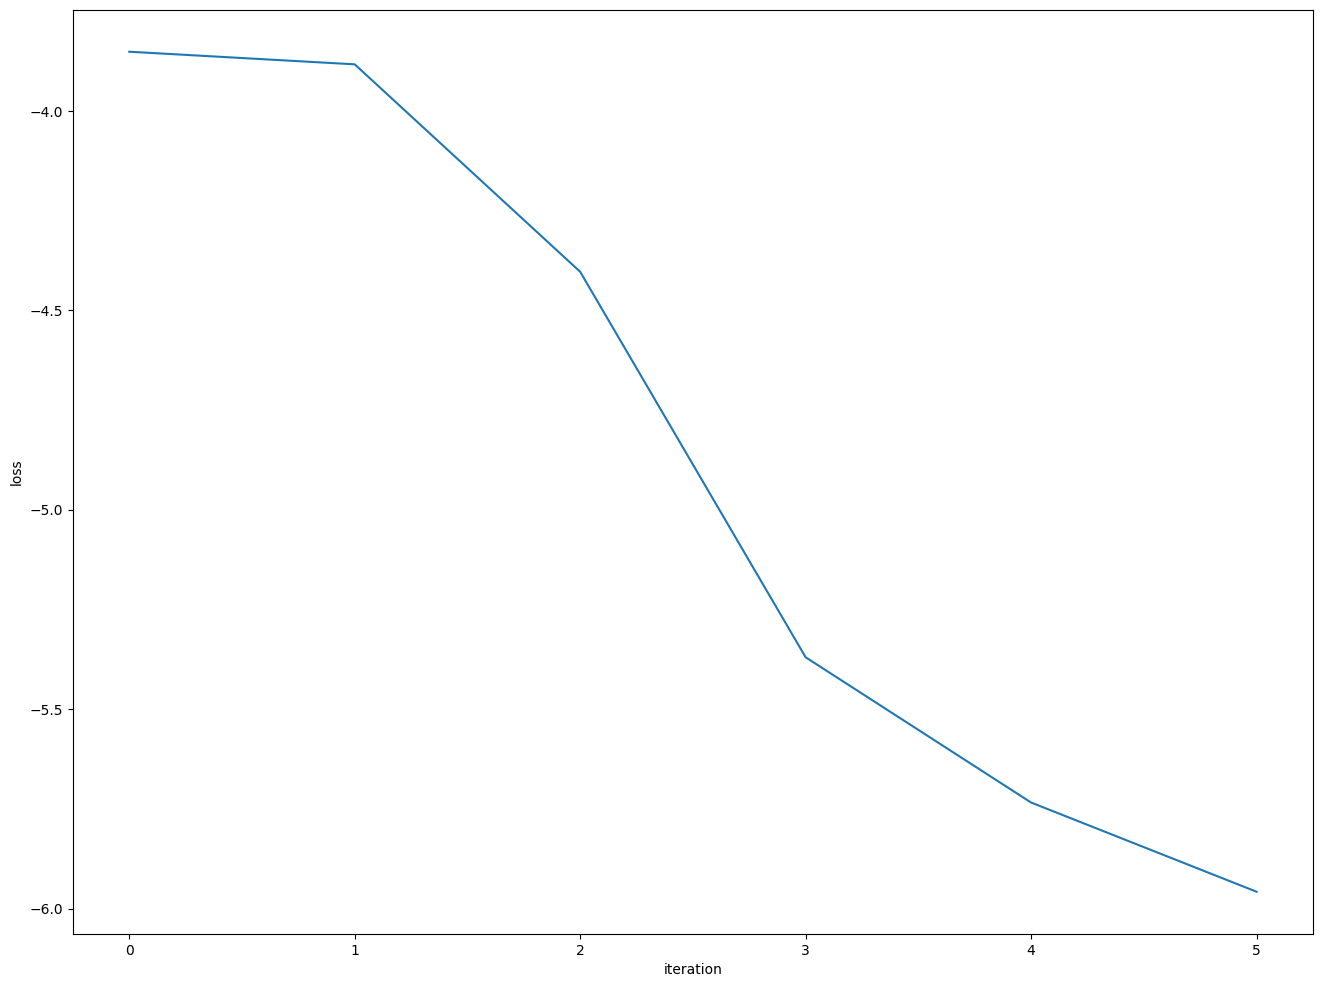

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

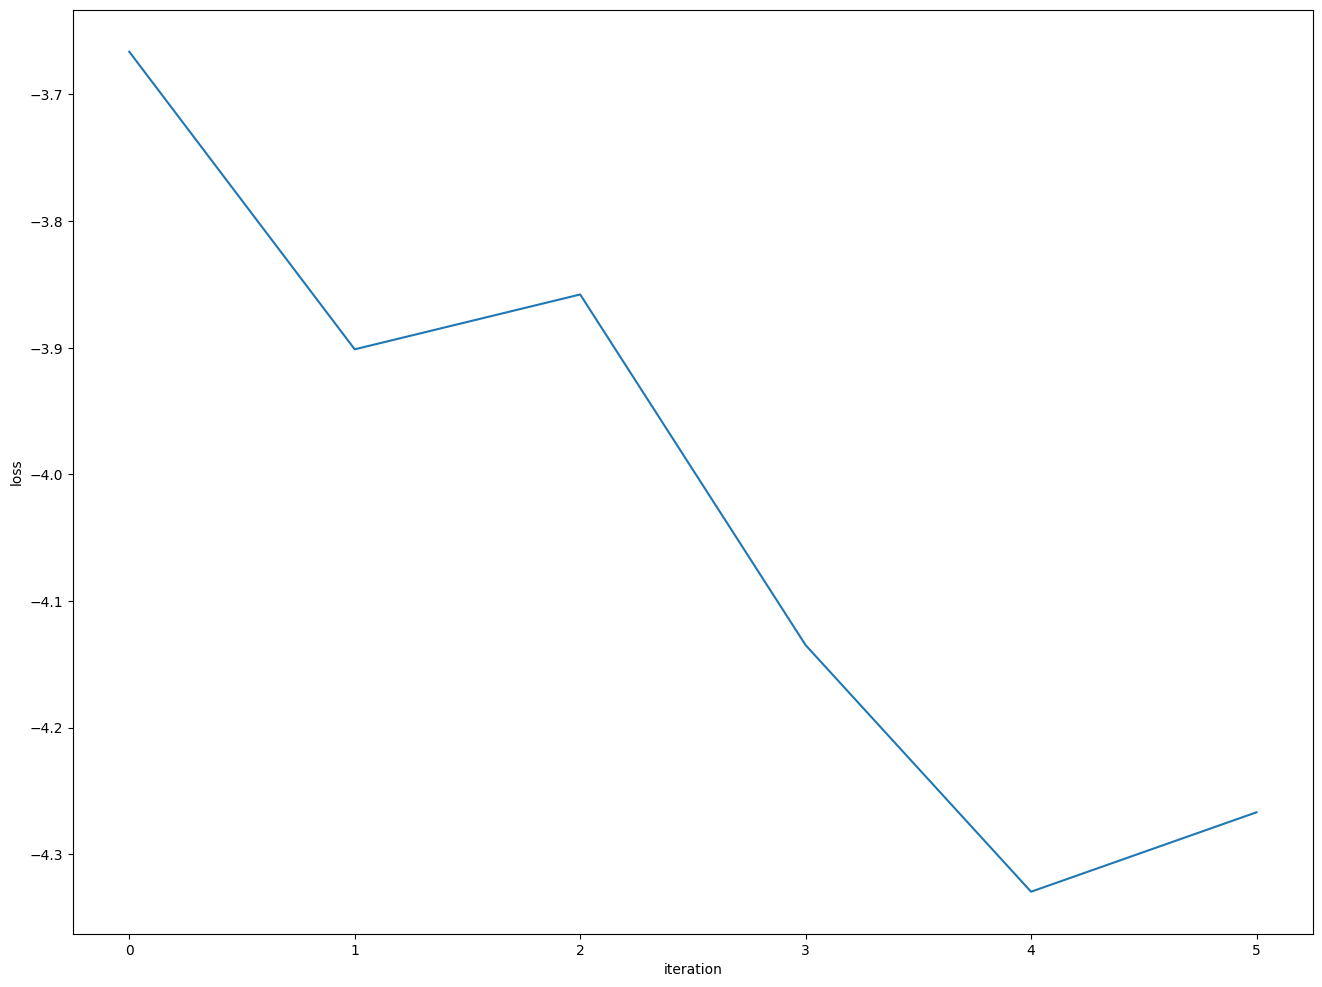

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")